In [1]:
%reload_ext autoreload
%autoreload
import sys
sys.path.append("../src")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import toml
import os
import re
import json

import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("colorblind"))
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from wordcloud import WordCloud
from IPython.display import JSON
from collections import Counter
from tqdm import tqdm
from pathlib import Path

from sapsam import parser, constants, detector, filters, SGXConverter
from sapsam.filters import DataFilter

pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [3]:
# mappings for namespaces and element types
with open(constants.SRC_ROOT / 'mappings.json') as json_file:
    mappings = json.load(json_file)

In [4]:
SGXConverter.convert_sgx_to_csv()

Found 0 SGX files.
Found 103 CSV files. Proceeding with analysis...


# Read Data

Let's first read in the meta data of all models in the dataset.

In [5]:
df_meta = parser.parse_model_metadata()
df_meta.head()

100%|█████████████████████████████████████████| 103/103 [02:22<00:00,  1.38s/it]


revision_id  \
model_id                                                             
1ba74449e9354d0c9d4798b4a6e915d0  5ed1535c95a342f4a414dd8c9b1b7df8   
1ba744cbcafb46c2a52482e36498a9bf  301bfb5af53c431a830a6e435de6a590   
1ba7587b3191422fb03a0e9ba92cebff  ac3baa3e59ca476396b4affa8e900c6f   
1ba758f87e744ff0bcb3119887cac8cc  da11513a93224fbbb2c34ef9c5cfcaa9   
1ba77121c3be44d6bd0b354727f9707b  70d06e82d8c344edab8b041f8b03161a   

                                                   organization_id  \
model_id                                                             
1ba74449e9354d0c9d4798b4a6e915d0  6c96d0b6e5e14eeaa9848f953a94e5f8   
1ba744cbcafb46c2a52482e36498a9bf  8af3fc1bb4b74e7c8c4089e4921d9056   
1ba7587b3191422fb03a0e9ba92cebff  36fbc1ee23334e1ab987b07d2108eef2   
1ba758f87e744ff0bcb3119887cac8cc  574093f96e5e4ff09a8b1f24eeb70284   
1ba77121c3be44d6bd0b354727f9707b  ff66cd6b779c44bba88ade8952d7e626   

                                             datetime description  \
model_id                                                            
1ba74449e9354d0c9d4798b4a6e915d0  2019-03-19 11:36:50         NaN   
1ba744cbcafb46c2a52482e36498a9bf  2020-03-23 17:26:03         NaN   
1ba7587b3191422fb03a0e9ba92cebff  2017-04-19 06:19:36         NaN   
1ba758f87e744ff0bcb3119887cac8cc  2021-02-21 13:14:32         NaN   
1ba77121c3be44d6bd0b354727f9707b  2020-06-30 07:12:48         NaN   

                                                                    name type  \
model_id                                                                        
1ba74449e9354d0c9d4798b4a6e915d0                                    Pivo  NaN   
1ba744cbcafb46c2a52482e36498a9bf                  Receipt of Application  NaN   
1ba7587b3191422fb03a0e9ba92cebff                710 BPMN Conference room  NaN   
1ba758f87e744ff0bcb3119887cac8cc                       ECU application p  NaN   
1ba77121c3be44d6bd0b354727f9707b  2.9.1 Elektronischer Auftrag erfassen   NaN   

                                                            namespace  
model_id                                                               
1ba74449e9354d0c9d4798b4a6e915d0  http://b3mn.org/stencilset/bpmn2.0#  
1ba744cbcafb46c2a52482e36498a9bf  http://b3mn.org/stencilset/bpmn2.0#  
1ba7587b3191422fb03a0e9ba92cebff  http://b3mn.org/stencilset/bpmn2.0#  
1ba758f87e744ff0bcb3119887cac8cc  http://b3mn.org/stencilset/bpmn2.0#  
1ba77121c3be44d6bd0b354727f9707b  http://b3mn.org/stencilset/bpmn2.0#

# Filtering example processes

The dataset includes the following vendor provided example processes.

In [6]:
import json
with open(constants.SRC_ROOT / "prefilled_example_processes.json") as data_file:    
    examples = json.load(data_file)

Here is the list of all example processes names:

In [7]:
example_names = []
for batch in examples["example_processes"]:
    example_names.extend(batch["content"])
example_names = set(example_names)
example_names

{'Arbeitsmittel beschaffen',
 'BANF-zu-Bestellung',
 'Bestellung-zu-Lieferung',
 'Bewerber prüfen',
 'Bewerbungseingang',
 'Check quantity and quality',
 'Commande de pièces',
 'Contrôler la quantité et la qualité',
 'Delivery-to-Payment',
 "Donner l'équipement de travail",
 'Ebene  2 - Prozessbereich: Personalwesen',
 'Ebene 1 - Prozesslandkarte ACME AG',
 'Ebene 2 - Prozessbereich: Auftragsdurchführung',
 'Ebene 2 - Prozessbereich: Produktentwicklung',
 'Employee Onboarding',
 "Installation d'un employé",
 'Level  2 - Process Area: Human Resources',
 'Level 1 - Value Chain ACME AG',
 'Level 2 - Process Area: Order Processing',
 'Level 2 - Process Area: Product Development',
 'Lieferung-zu-Bezahlung',
 'Menge und Qualität überprüfen',
 'Mitarbeiter Onboarding',
 "Niveau 1 – Chaine de valeur d'ACME AG",
 'Niveau 2 - Processus de développement produit',
 'Niveau 2 - Processus de gestion des commandes',
 'Niveau 2 - Processus des Ressources Humaines',
 'Procure parts',
 'Procurement of W

Now let's take a look at the number of examples processes in the dataset (note that we decide this based on the process name which is more of a rough estimate rather than an accurate number):

In [8]:
df_meta_examples = df_meta[df_meta["name"].isin(example_names)]
len(df_meta_examples)

471496

This is the percentage of example process from the dataset:

In [9]:
len(df_meta_examples)/len(df_meta)

0.4615853019811625

This is the number of models in the dataset without example processes (again, based on process names):

In [10]:
len(df_meta)-len(df_meta_examples)

549975

And the percentage of models in the dataset without example processes:

In [11]:
(len(df_meta)-len(df_meta_examples))/len(df_meta)

0.5384146980188376

We apply the filter to perform the analysis on the dataset without examples processes:

In [12]:
df_meta = DataFilter(df_meta)
df_meta = df_meta.filter_data("example_processes")
len(df_meta)

549975

We see that the size of the dataset now matches the previous calculation of the number of models without example processes.

# Modeling notations

We want to examine the usage of modeling notations in the dataset.

Let's start with counting the number of models in different modeling notations.

In [13]:
df_notations = pd.DataFrame.from_dict(dict(Counter(df_meta["namespace"])),orient = "index")
df_notations.reset_index(inplace=True)
df_notations.columns = ["Notation","Frequency"]
df_notations.sort_values(by=['Frequency'], ascending=False, inplace=True, ignore_index=True)

We map the namespaces to the common names for the modeling notations.

In [14]:
d_namespaces = mappings["namespaces"]
d_namespaces_reverse = {}
for k,v in d_namespaces.items():
    d_namespaces_reverse[v]=k
#df_notations = df_notations.replace({'Notation' : d_namespaces})

In [15]:
def map_namespaces(namespace):
    return d_namespaces.get(namespace, 'Unknown')
df_notations['Notation'] = df_notations['Notation'].map(lambda x: map_namespaces(x))
df_notations

Notation  Frequency
0                         BPMN 2.0     404243
1                              EPC      32339
2                      Value Chain      22857
3                         BPMN 1.1      15636
4                    UML 2.2 Class      14953
5                          DMN 1.0      12612
6                        Petri Net      11207
7                    ArchiMate 2.1      10956
8                     UML Use Case      10228
9                       Organigram       4568
10           BPMN 2.0 Choreography       4096
11           BPMN 2.0 Conversation       2788
12               FMC Block Diagram       1398
13                        CMMN 1.0        999
14                             CPN        385
15                     Journey Map        287
16                        YAWL 2.2        238
17  Process Documentation Template         86
18                          jBPM 4         76
19                          XForms         20
20                   Chen Notation          3

Now, we have the option to filter the data for the analysis.

In this case, the filter takes between **1** and **3** arguments, where "namespaces" is the filter type.

The **2nd** argument can be an integer, a notation name, or "max". It indicates the number of individual notations that should be kept in the filtered dataset, by descending frequency. The actual notation name can be used, if all others notations should be removed from the dataset.

The **3rd** argument is optional and represents a frequency threshold, under which the corresponding notations will be aggregated into a subgroup "Other".

For example, let's aggregate modeling notations which are used for less than 100 models in "Other".

In [16]:
if df_notations['Notation'].nunique() > 3:
    df_notations = DataFilter(df_notations)
    df_notations = df_notations.filter_data("namespaces", "max", 5)
df_notations

Notation  Frequency
0                         BPMN 2.0     404243
1                              EPC      32339
2                      Value Chain      22857
3                         BPMN 1.1      15636
4                    UML 2.2 Class      14953
5                          DMN 1.0      12612
6                        Petri Net      11207
7                    ArchiMate 2.1      10956
8                     UML Use Case      10228
9                       Organigram       4568
10           BPMN 2.0 Choreography       4096
11           BPMN 2.0 Conversation       2788
12               FMC Block Diagram       1398
13                        CMMN 1.0        999
14                             CPN        385
15                     Journey Map        287
16                        YAWL 2.2        238
17  Process Documentation Template         86
18                          jBPM 4         76
19                          XForms         20
20                           Other          3

We can visualise the number of models in different modeling notations.

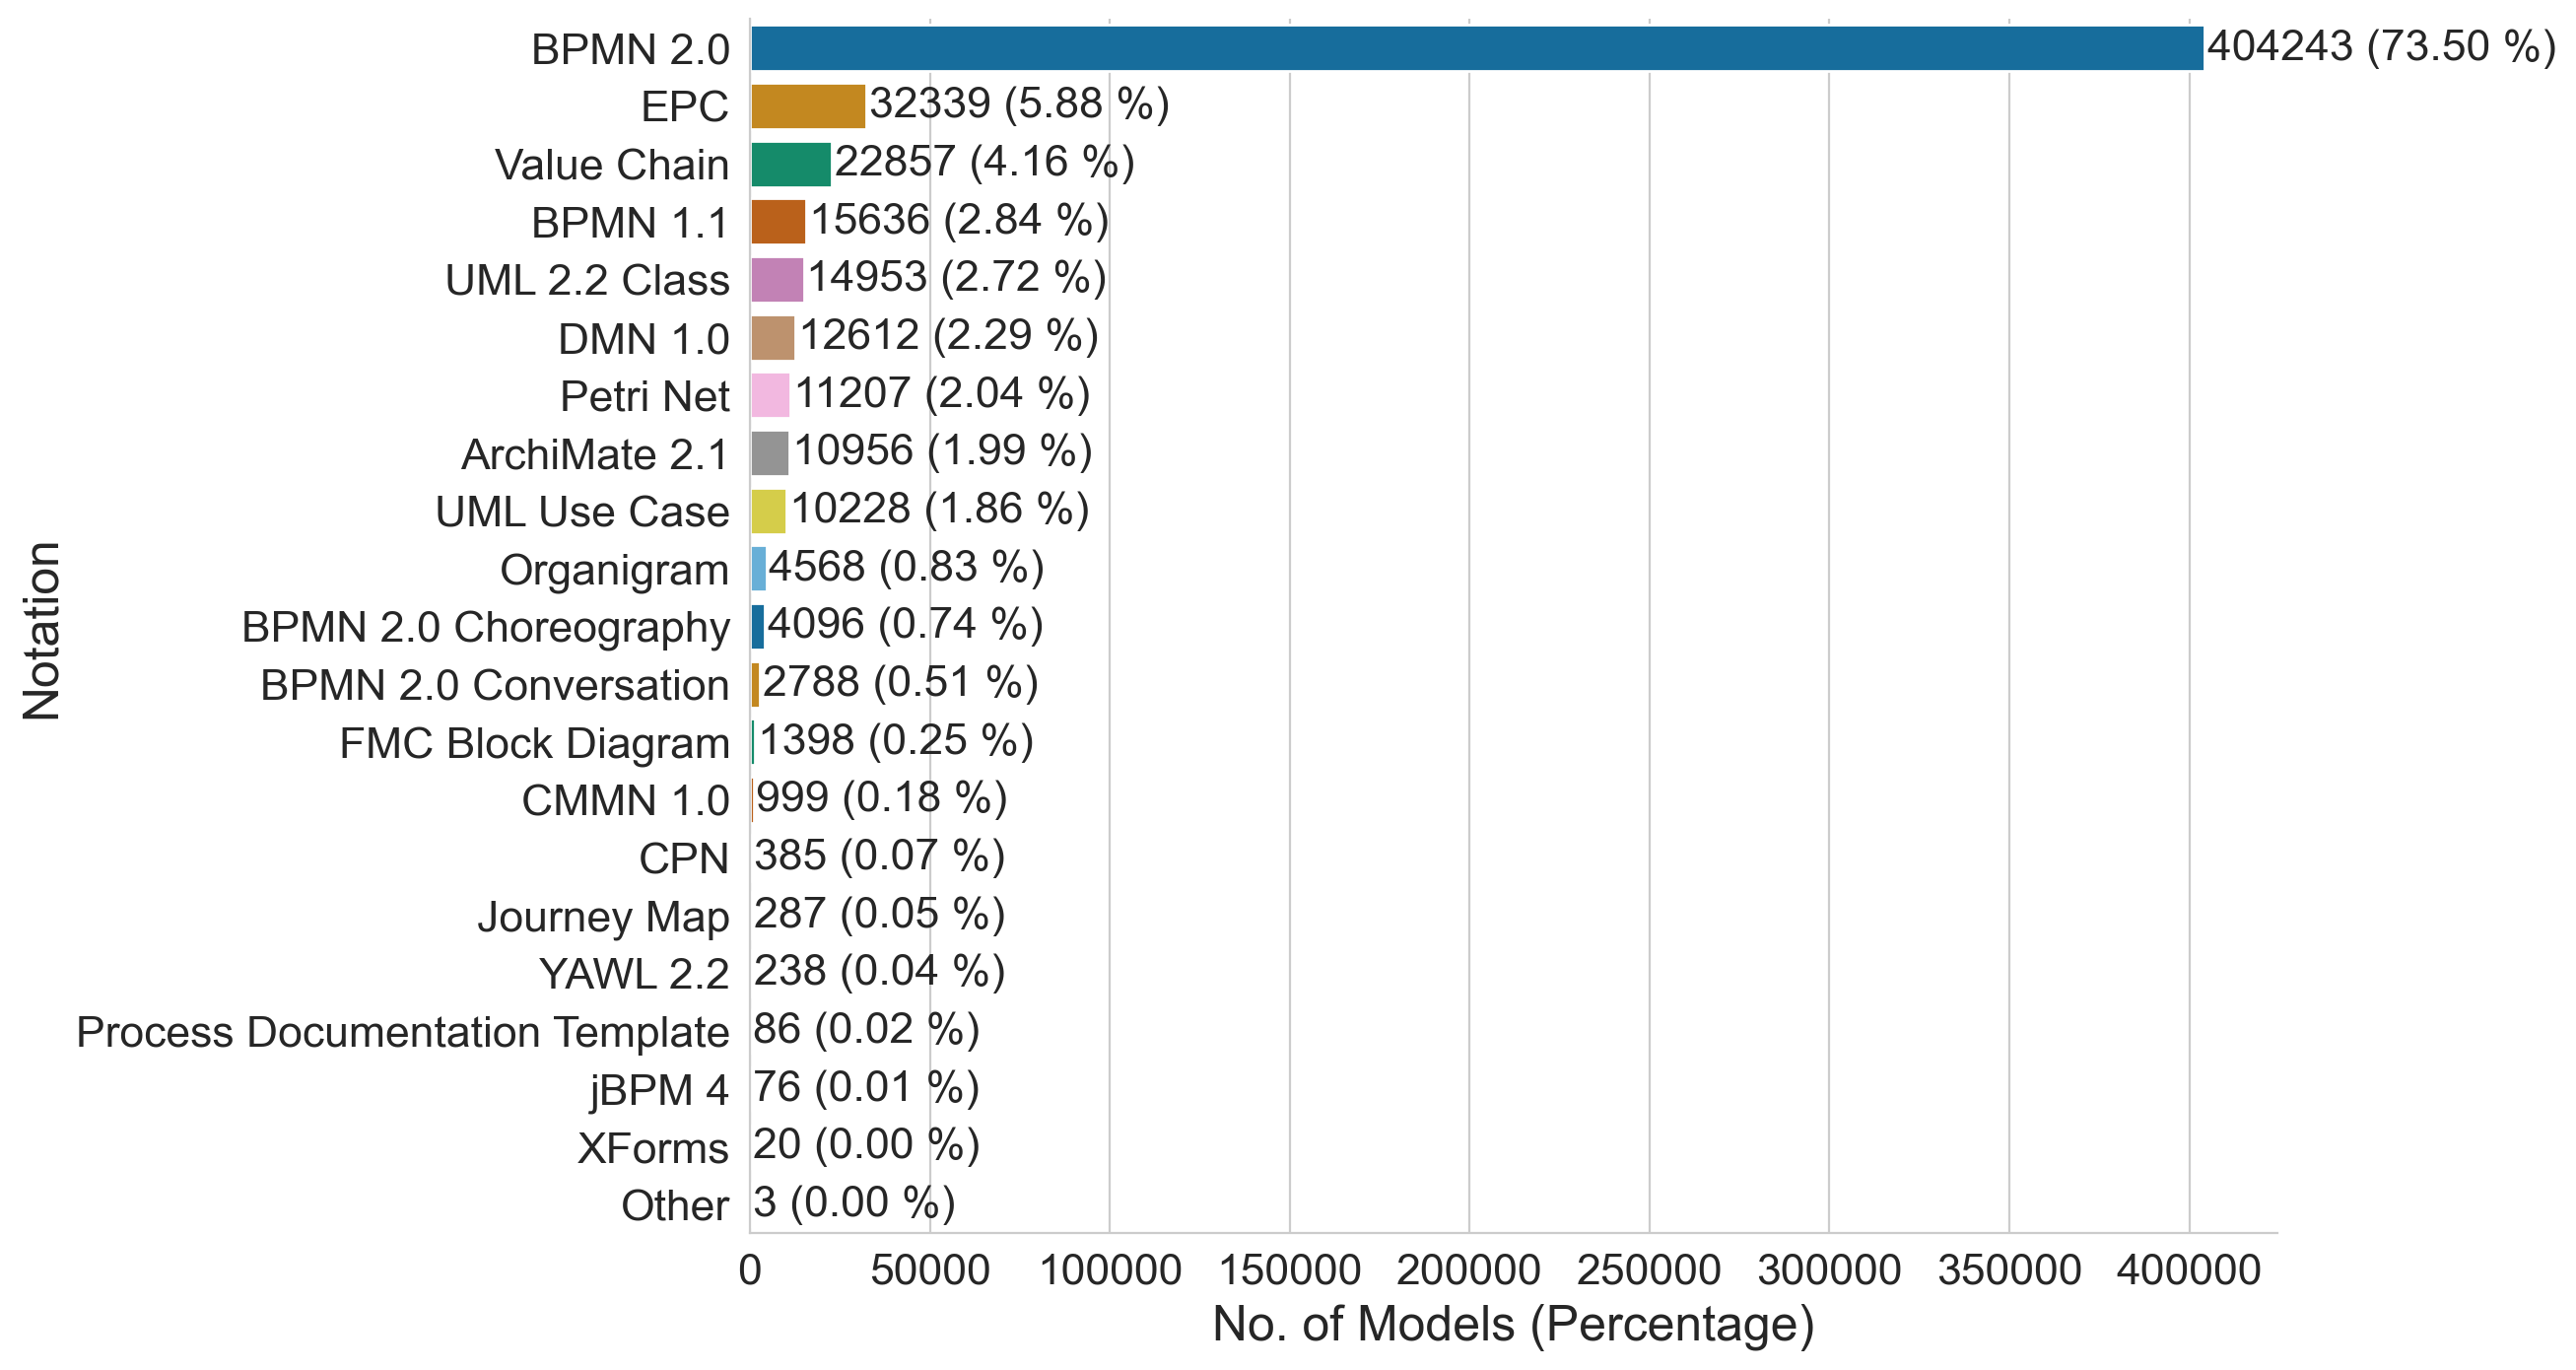

In [17]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 16})
containers_nb = df_notations['Notation'].nunique()
ax=sns.barplot(x="Frequency",y="Notation",hue="Notation",data=df_notations,estimator = np.max, errorbar=('ci', 0),palette = sns.color_palette("colorblind",n_colors=containers_nb),legend=False)
labels = [f'{val} ({val/ len(df_meta) * 100.0:.2f} %)' for val in df_notations["Frequency"]]
for container, label in zip(ax.containers, labels):
    ax.bar_label(container, label_type='edge', padding=1, labels=[label])
ax.set_xlabel('No. of Models (Percentage)', fontsize=18)
ax.set_ylabel('Notation', fontsize=18)
sns.despine()
#ax.set_xlim(0,700000)
plt.savefig(constants.FIGURES_ROOT / 'notations.pdf',transparent=True,bbox_inches = 'tight')

By using the datetime column, we can also consider the creation of models in different notations over time.

In [18]:
df_meta.datetime = pd.to_datetime(df_meta.datetime)

These are the first and the last created models in the dataset:

In [19]:
df_meta.sort_values('datetime').head(1)

revision_id  \
model_id                                                             
c1f9781d06594f068bee14f96d6744f3  43fe80a91c114d3ca121e8e8fb03a0a6   

                                                   organization_id  \
model_id                                                             
c1f9781d06594f068bee14f96d6744f3  c78f482cc9d54a278154a3d1671450db   

                                            datetime description  \
model_id                                                           
c1f9781d06594f068bee14f96d6744f3 2011-12-01 23:11:10         NaN   

                                              name       type  \
model_id                                                        
c1f9781d06594f068bee14f96d6744f3  Ampel - Lösung 1  Petrinets   

                                                             namespace  
model_id                                                                
c1f9781d06594f068bee14f96d6744f3  http://b3mn.org/stencilset/petrinet#

In [20]:
df_meta.sort_values('datetime').tail(1)

revision_id  \
model_id                                                             
0507df8deb7847e0a97d7515663e168d  9c6d4bceab634d7ca854edb71d3b5f0b   

                                                   organization_id  \
model_id                                                             
0507df8deb7847e0a97d7515663e168d  30da146aae4842cfab909b9723944f7a   

                                            datetime description  \
model_id                                                           
0507df8deb7847e0a97d7515663e168d 2021-09-22 03:19:14         NaN   

                                                                          name  \
model_id                                                                         
0507df8deb7847e0a97d7515663e168d  OSPCC Related Queries-As-Is Model  (Updated)   

                                 type                            namespace  
model_id                                                                    
0507df8deb7847e0a97d7515663e168d  NaN  http://b3mn.org/stencilset/bpmn2.0#

Let's check the creation of models over time for the five most used notations. We leave the "Other" subgroup out.

In [21]:
df_notations = DataFilter(df_notations)
selected_notations = df_notations.filter_data("namespaces", 5)
selected_notations['Notation'] = selected_notations['Notation'].map(d_namespaces_reverse)
selected_notations

Notation  Frequency
0              http://b3mn.org/stencilset/bpmn2.0#     404243
1                  http://b3mn.org/stencilset/epc#      32339
2  http://www.signavio.com/stencilsets/processmap#      22857
3              http://b3mn.org/stencilset/bpmn1.1#      15636
4          http://b3mn.org/stencilset/UML2.2Class#      14953

In [22]:
# handling the case where we have unknown namespaces in the dataset
# to inspect the unknown namespaces, comment the following line out:
#print(df_meta['namespace'].value_counts())
namespaces = mappings['namespaces'].keys()
df_meta['namespace'] = df_meta['namespace'].apply(lambda x: x if x in namespaces else 'Unknown')

In [23]:
df_meta_selected = df_meta[df_meta.namespace.isin(selected_notations['Notation'])].copy()
df_meta_selected['Count']= 1
df_meta_selected=df_meta_selected[['datetime','Count','namespace']].sort_values('datetime')
df_meta_selected.set_index('datetime', inplace=True)

We count the number of models created per year.

In [24]:
df_meta_selected = df_meta_selected.groupby('namespace',observed=False).resample('YE').sum(numeric_only=True,min_count=1)
df_meta_selected = df_meta_selected['Count'].fillna(0)
df_meta_selected = df_meta_selected.reset_index()
df_meta_selected['Year'] = df_meta_selected['datetime'].apply(lambda x:x.year)

To ensure index consistency in the plot, we pivot the table and fill the count for missing years with 0. This step is a precaution for the case when a notation hasn't been created for a given year.

In [25]:
df_meta_selected = df_meta_selected.pivot_table(index='Year', columns='namespace', values='Count', fill_value=0, observed=False)
df_meta_selected = df_meta_selected.reset_index().melt(var_name='namespace', value_name='Count', id_vars='Year')
df_meta_selected = df_meta_selected[['namespace', 'Count', 'Year']]

df_meta_selected = df_meta_selected.replace({'namespace' : d_namespaces})
df_meta_selected.head()

namespace   Count  Year
0  UML 2.2 Class     0.0  2012
1  UML 2.2 Class     0.0  2013
2  UML 2.2 Class     0.0  2014
3  UML 2.2 Class   193.0  2015
4  UML 2.2 Class  1127.0  2016

Since the number of models created before 2015 in the dataset is rather small, we visualize the numbers starting in 2015. Also, the dataset only contains models until September 2021, so we exclude 2021, too.

In [26]:
sum(df_meta['datetime'].apply(lambda x: x.year)<2015)

24

In [27]:
df_meta_selected=df_meta_selected[df_meta_selected['Year']>=2015]
df_meta_selected=df_meta_selected[df_meta_selected['Year']<2024]
df_meta_selected.head()

namespace   Count  Year
3  UML 2.2 Class   193.0  2015
4  UML 2.2 Class  1127.0  2016
5  UML 2.2 Class  1773.0  2017
6  UML 2.2 Class  1669.0  2018
7  UML 2.2 Class  1174.0  2019

In [28]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

<Figure size 2000x1000 with 0 Axes>

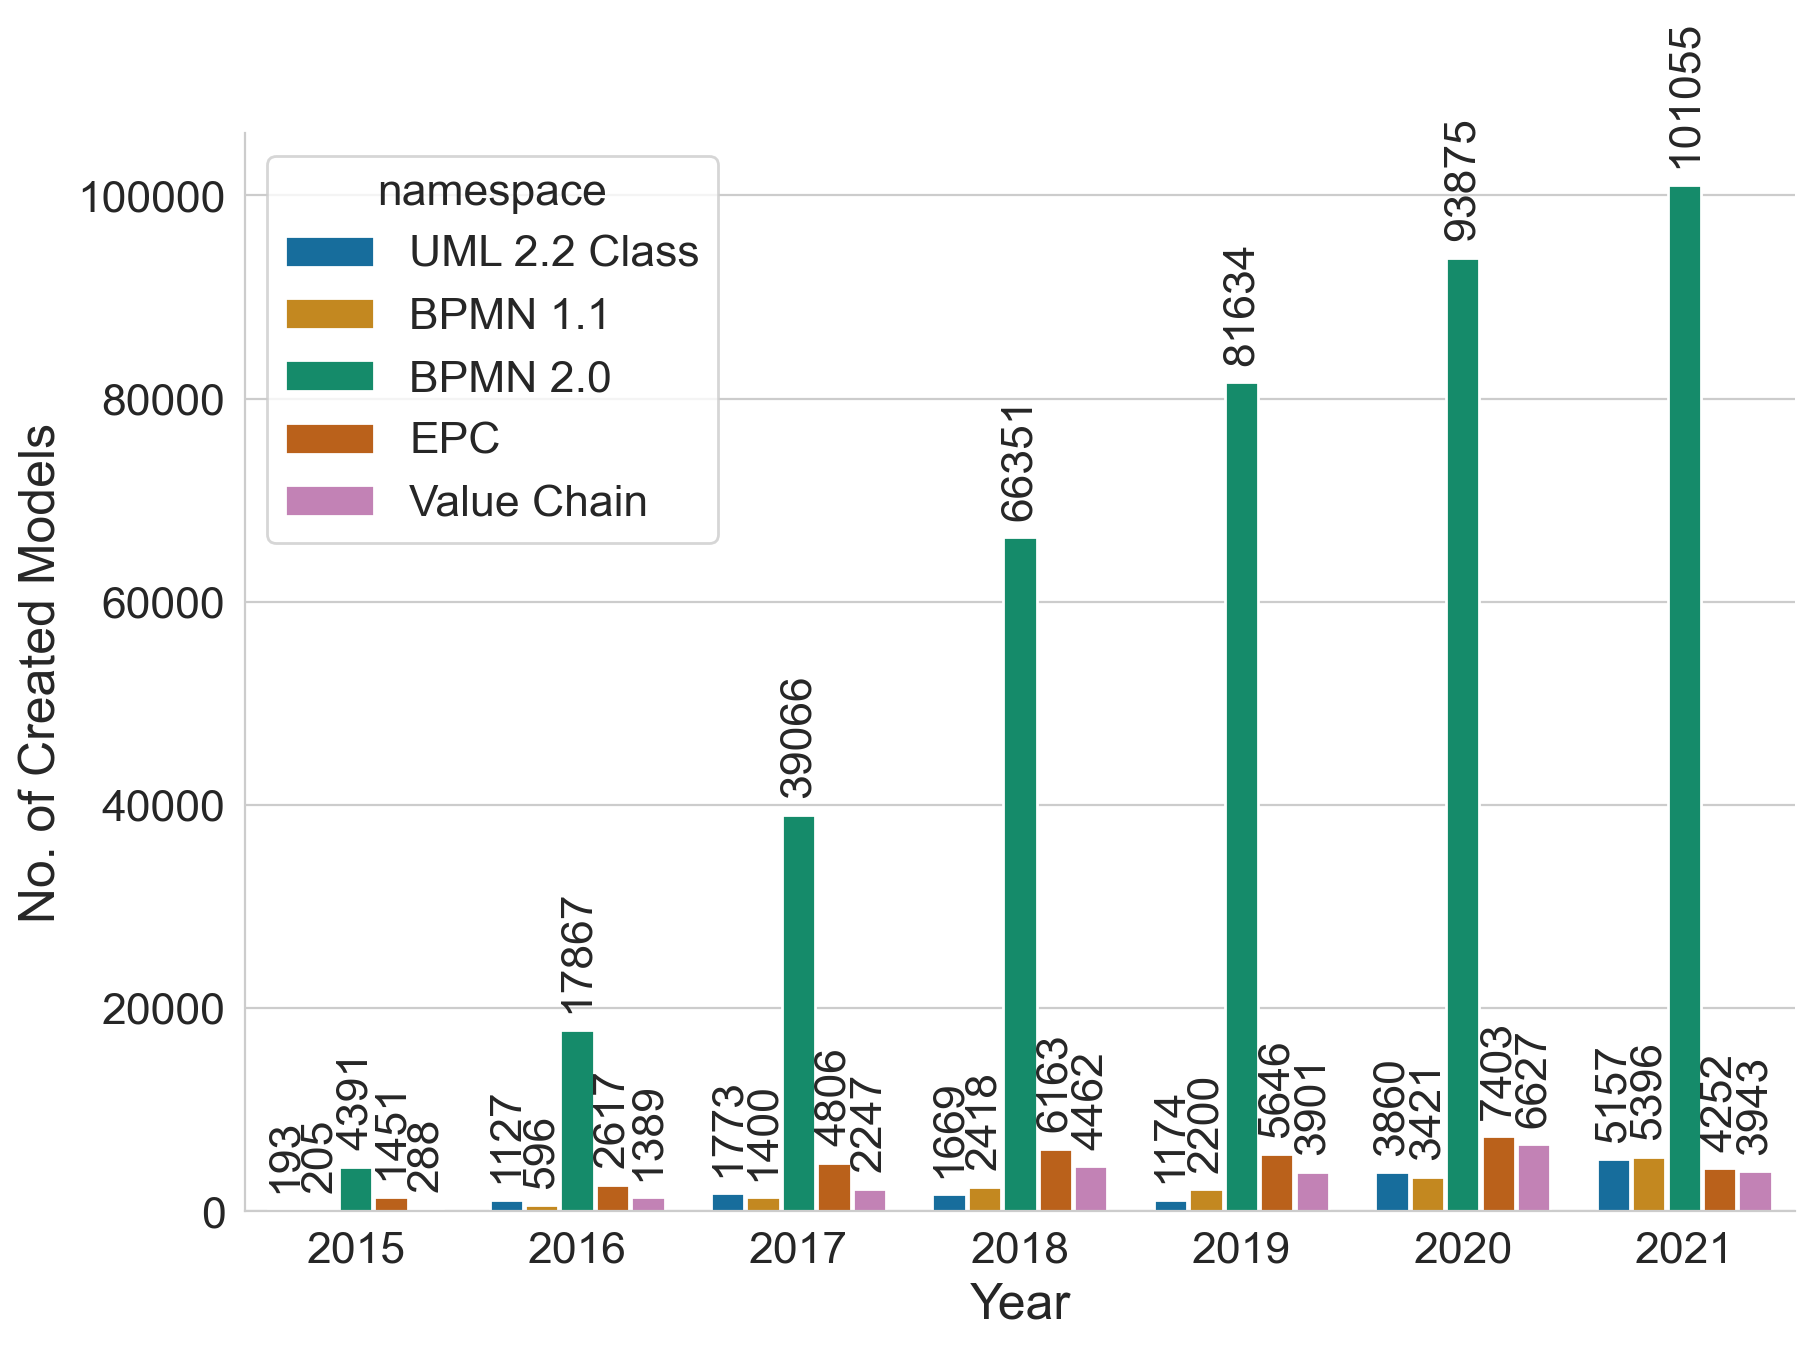

In [29]:
plt.figure(figsize=(20,10))
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(data=df_meta_selected,x='Year', y='Count', hue='namespace',ax=ax)
#plt.legend(title='', loc='upper left')
change_width(ax, .15)
for container in ax.containers:
    ax.bar_label(container, padding = 6, rotation='vertical')
ax.set_xlabel('Year',fontsize=18)
ax.set_ylabel('No. of Created Models',fontsize=18)
sns.despine()

We can also visualize this as stacked plot.

In [30]:
selected_notations_short = [d_namespaces[n] for n in selected_notations['Notation']]
d_stacked = dict()
for n in selected_notations_short:
    d_stacked[n] = df_meta_selected[df_meta_selected["namespace"]==n]["Count"].values
df_stacked = pd.DataFrame(d_stacked, index=df_meta_selected.Year.unique())
df_stacked.sort_index(ascending=False,inplace=True)
df_stacked

BPMN 2.0     EPC  Value Chain  BPMN 1.1  UML 2.2 Class
2021  101055.0  4252.0       3943.0    5396.0         5157.0
2020   93875.0  7403.0       6627.0    3421.0         3860.0
2019   81634.0  5646.0       3901.0    2200.0         1174.0
2018   66351.0  6163.0       4462.0    2418.0         1669.0
2017   39066.0  4806.0       2247.0    1400.0         1773.0
2016   17867.0  2617.0       1389.0     596.0         1127.0
2015    4391.0  1451.0        288.0     205.0          193.0

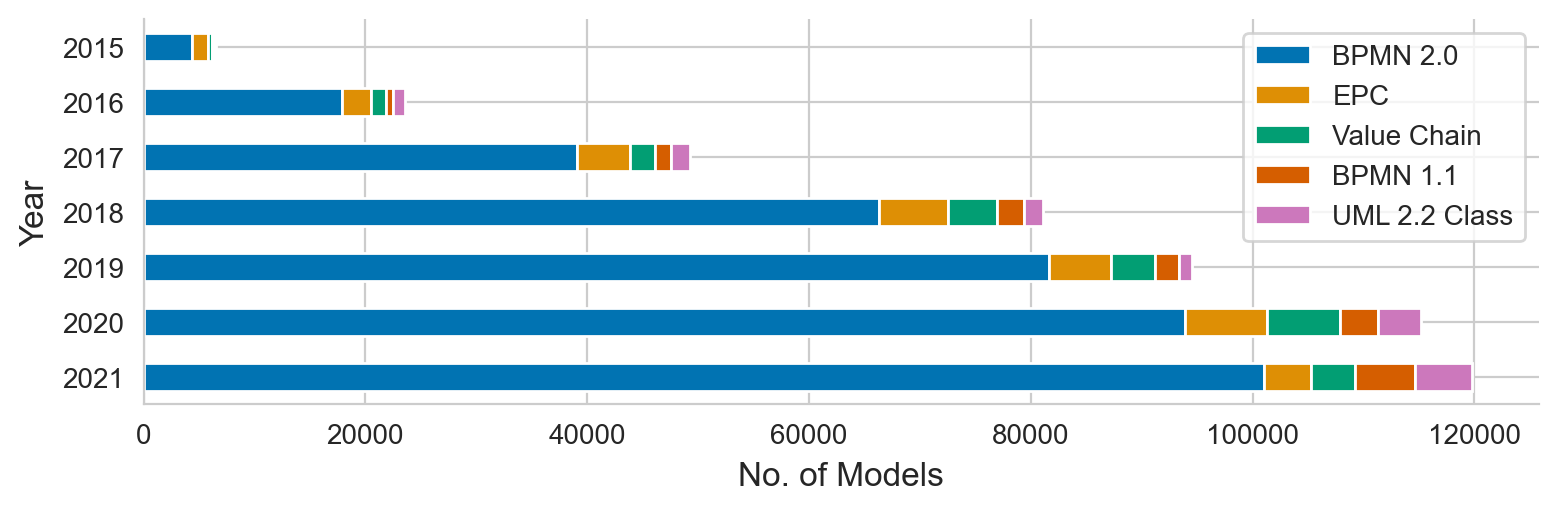

In [31]:
plt.rcParams.update({'font.size': 10})
ax = df_stacked.plot(kind='barh', stacked=True,figsize=(9,2.5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("No. of Models",fontsize=12)
ax.set_ylabel("Year",fontsize=12)
plt.savefig(constants.FIGURES_ROOT / 'notations_over_time.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

# Parse BPMN 2.0 models

For further analysis, we concentrate on BPMN 2.0 models as primary used notation.

In [32]:
df_meta_bpmn = df_meta[df_meta.namespace == constants.BPMN2_NAMESPACE]
df_meta_bpmn.head()

revision_id  \
model_id                                                             
1ba74449e9354d0c9d4798b4a6e915d0  5ed1535c95a342f4a414dd8c9b1b7df8   
1ba7587b3191422fb03a0e9ba92cebff  ac3baa3e59ca476396b4affa8e900c6f   
1ba758f87e744ff0bcb3119887cac8cc  da11513a93224fbbb2c34ef9c5cfcaa9   
1ba77121c3be44d6bd0b354727f9707b  70d06e82d8c344edab8b041f8b03161a   
1ba7b40cfd804781a4aaa394635d1760  e47efaa6dcde4a4586b7ffcb301996d5   

                                                   organization_id  \
model_id                                                             
1ba74449e9354d0c9d4798b4a6e915d0  6c96d0b6e5e14eeaa9848f953a94e5f8   
1ba7587b3191422fb03a0e9ba92cebff  36fbc1ee23334e1ab987b07d2108eef2   
1ba758f87e744ff0bcb3119887cac8cc  574093f96e5e4ff09a8b1f24eeb70284   
1ba77121c3be44d6bd0b354727f9707b  ff66cd6b779c44bba88ade8952d7e626   
1ba7b40cfd804781a4aaa394635d1760  c41660388a04449a995dccf97d894f46   

                                            datetime description  \
model_id                                                           
1ba74449e9354d0c9d4798b4a6e915d0 2019-03-19 11:36:50         NaN   
1ba7587b3191422fb03a0e9ba92cebff 2017-04-19 06:19:36         NaN   
1ba758f87e744ff0bcb3119887cac8cc 2021-02-21 13:14:32         NaN   
1ba77121c3be44d6bd0b354727f9707b 2020-06-30 07:12:48         NaN   
1ba7b40cfd804781a4aaa394635d1760 2019-06-12 03:11:21         NaN   

                                                                    name type  \
model_id                                                                        
1ba74449e9354d0c9d4798b4a6e915d0                                    Pivo  NaN   
1ba7587b3191422fb03a0e9ba92cebff                710 BPMN Conference room  NaN   
1ba758f87e744ff0bcb3119887cac8cc                       ECU application p  NaN   
1ba77121c3be44d6bd0b354727f9707b  2.9.1 Elektronischer Auftrag erfassen   NaN   
1ba7b40cfd804781a4aaa394635d1760                           12345678_rev4  NaN   

                                                            namespace  
model_id                                                               
1ba74449e9354d0c9d4798b4a6e915d0  http://b3mn.org/stencilset/bpmn2.0#  
1ba7587b3191422fb03a0e9ba92cebff  http://b3mn.org/stencilset/bpmn2.0#  
1ba758f87e744ff0bcb3119887cac8cc  http://b3mn.org/stencilset/bpmn2.0#  
1ba77121c3be44d6bd0b354727f9707b  http://b3mn.org/stencilset/bpmn2.0#  
1ba7b40cfd804781a4aaa394635d1760  http://b3mn.org/stencilset/bpmn2.0#

Number of BPMN 2.0 models:

In [33]:
len(df_meta_bpmn)

404243

We use the BPMNModelParser to parse the BPMN 2.0 models. In case we have already parsed them, we load the parsed data from the pkl file.

In [34]:
p = parser.BpmnModelParser() # comment this line if you have already created the pkl file
df_bpmn = p.parse_model_elements() # comment this line if you have already created the pkl file
df_bpmn.to_pickle(constants.DATA_INTERIM / "bpmn_elements.pkl") # comment this line if you have already created the pkl file
#df_bpmn = pd.read_pickle(constants.DATA_INTERIM / "bpmn_elements.pkl") # uncomment this line if you have already created the pkl file
df_bpmn.head()

100%|█████████████████████████████████████████| 103/103 [18:27<00:00, 10.75s/it]


category  \
model_id                         element_id                                                    
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD        MessageFlow   
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE               Pool   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803               Lane   
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  StartMessageEvent   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262       SequenceFlow   

                                                                                          label  \
model_id                         element_id                                                       
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD                         
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE             Konobar\n   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803                         
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  Narudžba primljena\n   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262                         

                                                                          glossary_link_id  \
model_id                         element_id                                                  
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD             None   
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE             None   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803             None   
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246             None   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262             None   

                                                                           name  
model_id                         element_id                                      
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD  Pivo  
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE  Pivo  
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803  Pivo  
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  Pivo  
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262  Pivo

Number of BPMN 2.0 models from the parser:

In [35]:
index = df_bpmn.index.get_level_values('model_id')
index.nunique()

605506

Number of BPMN 2.0 models from the parser after filtering out example processes, models with less than 5 elements, and models with no task, start event or end event elements:

In [36]:
df_bpmn = DataFilter(df_bpmn).filter_data("example_processes_bpmn")
df_bpmn = DataFilter(df_bpmn).filter_data("models", 5)

Filtering out example processes models...
Keeping 390954 out of 605506 from the dataset
Dataset has been filtered down to 390954 models, a decrease of 35.43%.

Filtering out models with less than 5 elements...
Keeping 386356 out of 390954 from the dataset
Filtering out models with no start, end, or task elements...
Keeping 357352 out of 386356 from the dataset

Dataset has been filtered down to 357352 models, a decrease of 8.59%.


When compared to the analysis of the dataset metadata, we notice that after the example processes filtering, the count of BPMN 2.0 models is slightly lower. This difference shows there are some empty BPMN 2.0 models in the dataset, which do not contain any elements and thus ignored during the parsing.

The total number of elements from all BPMN 2.0 models is:

In [37]:
len(df_bpmn)

18918360

# Languages

We use spaCy to detect the language of a model. More specifically, we use a model's element labels to decide on its language.

In [38]:
try:
    nlp = spacy.load("en_core_web_sm")
    print("Package already installed")
except:
    print("Installing package...")
    !python -m spacy download en_core_web_sm > /dev/null
    print("\033[92m\u2713\033[0m Download and installation successful")

Installing package...
✓ Download and installation successful


In [39]:
ld = detector.ModelLanguageDetector(0.8) # comment this line if you have already created the pkl file
df_language = ld.get_detected_natural_language_from_bpmn_model(df_bpmn) # comment this line if you have already created the pkl file
df_language.to_pickle(constants.DATA_INTERIM / "bpmn_languages.pkl") # comment this line if you have already created the pkl file
# df_language = pd.read_pickle(constants.DATA_INTERIM / "bpmn_languages.pkl") # uncomment this line if you have already created the pkl file
df_language.head()

100%|█████████████████████████████████| 357352/357352 [1:31:38<00:00, 64.99it/s]


label  \
model_id                                                                              
0000150e890c45928d26584d491ada68   CredibilityAssessment IN {rejected}\n Checked...   
00003a67300748639e4bc21398bb5ede                                                      
00005cea16fd426881c7f1619e30b804   Nein Ja Urlaubsplanung Lohnbuchhaltung BRZ  J...   
0000c8488ca54f7cafe9556e9538defd   AI AH AG AF AE AD AC AB AA Z Y X BO BN BM BL ...   
00011e4ecbf740d4bd4dd71a5c845c4d   Not received Received Send \ninformation & In...   

                                                            name  \
model_id                                                           
0000150e890c45928d26584d491ada68                             P5    
00003a67300748639e4bc21398bb5ede                    Test process   
00005cea16fd426881c7f1619e30b804  Personalprozess Urlaubsplanung   
0000c8488ca54f7cafe9556e9538defd                        12345678   
00011e4ecbf740d4bd4dd71a5c845c4d     Homework Jane Doe S12345678   

                                 detected_natural_language  
model_id                                                    
0000150e890c45928d26584d491ada68                        en  
00003a67300748639e4bc21398bb5ede                   UNKNOWN  
00005cea16fd426881c7f1619e30b804                        de  
0000c8488ca54f7cafe9556e9538defd                        de  
00011e4ecbf740d4bd4dd71a5c845c4d                        en

Let's plot the use of different languages across the dataset.

In [40]:
from langcodes import *
def get_language_from_code(code):
    return Language.make(language=code).display_name()

In [41]:
d_lang =  dict(Counter(df_language["detected_natural_language"]))
df_lang = pd.DataFrame.from_dict(d_lang,orient="index")
df_lang = df_lang.reset_index().rename(columns={"index": "Language",0: "No. of Models"})
df_lang["Language"] = df_lang["Language"].apply(lambda x: get_language_from_code(x))
df_lang.sort_values("No. of Models",ascending=False,inplace=True)
df_lang.reset_index(inplace=True)
df_lang.drop("index",inplace=True,axis=1)
df_lang

Language  No. of Models
0                      English         175525
1                       German          93738
2                      Italian          18281
3                      Spanish          16037
4                       French           8171
5                     Croatian           8004
6                   Portuguese           6043
7                        Dutch           4500
8                     Estonian           4370
9                    Slovenian           3884
10                    Romanian           3204
11                  Indonesian           2759
12                     Swedish           2104
13                   Hungarian           1392
14                      Polish           1389
15                       Greek           1383
16  Unknown language [UNKNOWN]           1337
17                      Danish            494
18                   Norwegian            452
19                     Catalan            425
20                     Finnish            380
21                  Vietnamese            374
22                     Turkish            368
23                       Welsh            356
24                   Afrikaans            344
25                    Japanese            284
26                     Latvian            253
27                       Czech            253
28    Unknown language [zh-cn]            192
29                      Slovak            170
30                      Somali            156
31                    Albanian            153
32                     Russian            143
33                     Tagalog            137
34                      Korean             83
35                  Macedonian             79
36                  Lithuanian             66
37                     Persian             36
38                     Swahili             25
39                      Arabic              4
40                        Thai              2
41                   Ukrainian              1
42                   Bulgarian              1

We only plot the 10 most common languages.

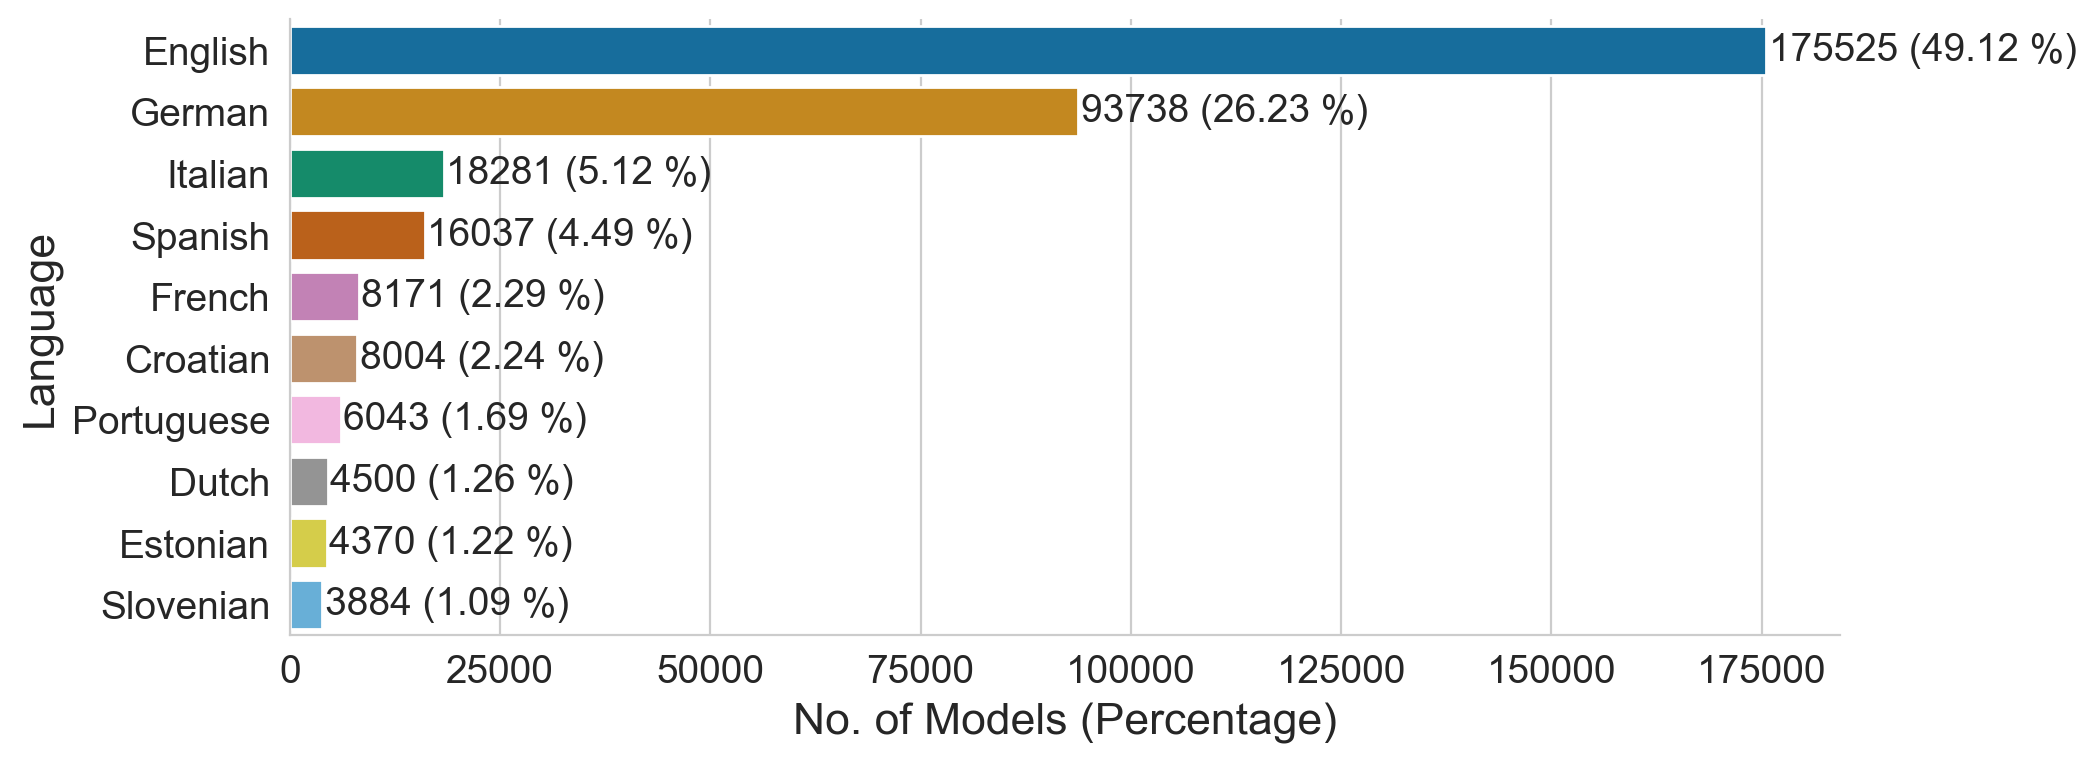

In [42]:
nr_most_common = 10
total = df_lang['No. of Models'].sum()
df_lang = df_lang.iloc[:nr_most_common]
plt.figure(figsize=(10,4))
plt.rcParams.update({'font.size': 14})
ax = sns.barplot(x="No. of Models", y="Language", hue="Language", data=df_lang)
labels = [f'{val} ({val/ total * 100.0:.2f} %)' for val in df_lang['No. of Models']]
for container, label in zip(ax.containers, labels):
    ax.bar_label(container, label_type='edge', padding=1, labels=[label])
#ax.bar_label(ax.containers[0],label_type='edge', padding=4, labels=)
ax.set_xlabel("No. of Models (Percentage)",fontsize=16)
ax.set_ylabel("Language",fontsize=16)
sns.despine()
plt.savefig(constants.FIGURES_ROOT / 'languages.pdf',transparent=True,bbox_inches = 'tight')

# Element types 

Next, we want to examine the usage of element types in the BPMN models.

In [43]:
def get_element_count(df_model):
    cnts = dict(Counter(df_model["category"].values))
    cnts["total_count"] = sum(cnts.values())
    return cnts

In [44]:
cnt_elements = pd.DataFrame.from_records(get_element_count(df_bpmn.loc[s]) for s in tqdm(df_bpmn.index.unique("model_id"))).fillna(0).convert_dtypes() # comment this line if you have already created the pkl file
cnt_elements.to_pickle(constants.DATA_INTERIM / "bpmn_cnt_elements.pkl") # comment this line if you have already created the pkl file
# cnt_elements = pd.read_pickle(constants.DATA_INTERIM / "bpmn_cnt_elements.pkl") # uncomment this line if you have already created the pkl file
cnt_elements.head()

100%|█████████████████████████████████| 357352/357352 [01:07<00:00, 5265.20it/s]


SequenceFlow  Pool  Lane  Task  EndNoneEvent  ParallelGateway  \
0            28     1     5    13             2                2   
1             8     0     0     4             1                0   
2            14     1     3     7             3                2   
3            47     5     5    21             2                0   
4            43     3     3    16             1                0   

   Exclusive_Databased_Gateway  StartNoneEvent  EventbasedGateway  \
0                            4               1                  1   
1                            2               1                  0   
2                            1               2                  0   
3                            6               2                  0   
4                            6               0                  0   

   IntermediateMessageEventCatching  IntermediateTimerEvent  total_count  \
0                                 1                       2           60   
1                                 0                       0           16   
2                                 0                       0           36   
3                                 8                       0          122   
4                                 3                       5          109   

   Association_Undirected  ITSystem  MessageFlow  \
0                       0         0            0   
1                       0         0            0   
2                       2         1            0   
3                       1         0            7   
4                       0         0           15   

   IntermediateMessageEventThrowing  Association_Unidirectional  \
0                                 0                           0   
1                                 0                           0   
2                                 0                           0   
3                                 3                           2   
4                                 4                           2   

   EndMessageEvent  StartMessageEvent  EventSubprocess  TextAnnotation  \
0                0                  0                0               0   
1                0                  0                0               0   
2                0                  0                0               0   
3                6                  3                1               1   
4                4                  1                0               0   

   DataObject  InclusiveGateway  DataStore  CollapsedPool  Subprocess  \
0           0                 0          0              0           0   
1           0                 0          0              0           0   
2           0                 0          0              0           0   
3           2                 0          0              0           0   
4           1                 1          1              0           0   

   CollapsedEventSubprocess  IntermediateEvent  StartTimerEvent  \
0                         0                  0                0   
1                         0                  0                0   
2                         0                  0                0   
3                         0                  0                0   
4                         0                  0                0   

   IntermediateMultipleEventCatching  EndTerminateEvent  \
0                                  0                  0   
1                                  0                  0   
2                                  0                  0   
3                                  0                  0   
4                                  0                  0   

   IntermediateCompensationEventCatching  EndCancelEvent  \
0                                      0               0   
1                                      0               0   
2                                      0               0   
3                                      0               0   
4                                      0               0   

   

These are the statistics of the different element types per model:

In [45]:
# print(cnt_elements.columns)
# cnt_elements.drop(columns=["total_count","gdottedline","gdashedline","gtext","gellipse","gdiamond","grect"]).select_dtypes(np.number).gt(0).sum(axis=1).describe()
cnt_elements.drop(columns=["total_count"]).select_dtypes(np.number).gt(0).sum(axis=1).describe()

count     357352.0
mean     10.305539
std       4.025805
min            3.0
25%            7.0
50%           10.0
75%           13.0
max           62.0
dtype: Float64

Thus, on average, a BPMN 2.0 model contains 11.3 different element types (median: 11).

We can also investigate the number of models that contain at least one instance of a particular element type. This gives us an indication of which element types are most important in practice.

In [46]:
df_cnts = (
    df_bpmn.groupby("model_id").category
    .value_counts()
    .to_frame("count")
    .unstack()
    .droplevel(0, axis='columns') # drop first level column level "count" that unstack produces
    .fillna(0)
    .convert_dtypes()
)
df_cnts.head()

category                          Association_Bidirectional  \
model_id                                                      
0000150e890c45928d26584d491ada68                          0   
00003a67300748639e4bc21398bb5ede                          0   
00005cea16fd426881c7f1619e30b804                          0   
0000c8488ca54f7cafe9556e9538defd                          0   
00011e4ecbf740d4bd4dd71a5c845c4d                          0   

category                          Association_Undirected  \
model_id                                                   
0000150e890c45928d26584d491ada68                       0   
00003a67300748639e4bc21398bb5ede                       0   
00005cea16fd426881c7f1619e30b804                       2   
0000c8488ca54f7cafe9556e9538defd                       1   
00011e4ecbf740d4bd4dd71a5c845c4d                       0   

category                          Association_Unidirectional  \
model_id                                                       
0000150e890c45928d26584d491ada68                           0   
00003a67300748639e4bc21398bb5ede                           0   
00005cea16fd426881c7f1619e30b804                           0   
0000c8488ca54f7cafe9556e9538defd                           2   
00011e4ecbf740d4bd4dd71a5c845c4d                           2   

category                          CollapsedEventSubprocess  CollapsedPool  \
model_id                                                                    
0000150e890c45928d26584d491ada68                         0              0   
00003a67300748639e4bc21398bb5ede                         0              0   
00005cea16fd426881c7f1619e30b804                         0              0   
0000c8488ca54f7cafe9556e9538defd                         0              0   
00011e4ecbf740d4bd4dd71a5c845c4d                         0              0   

category                          CollapsedSubprocess  CollapsedVerticalPool  \
model_id                                                                       
0000150e890c45928d26584d491ada68                    0                      0   
00003a67300748639e4bc21398bb5ede                    0                      0   
00005cea16fd426881c7f1619e30b804                    0                      0   
0000c8488ca54f7cafe9556e9538defd                    0                      0   
00011e4ecbf740d4bd4dd71a5c845c4d                    0                      0   

category                          ComplexGateway  DataObject  DataStore  \
model_id                                                                  
0000150e890c45928d26584d491ada68               0           0          0   
00003a67300748639e4bc21398bb5ede               0           0          0   
00005cea16fd426881c7f1619e30b804               0           0          0   
0000c8488ca54f7cafe9556e9538defd               0           2          0   
00011e4ecbf740d4bd4dd71a5c845c4d               0           1          1   

category                          EndCancelEvent  EndCompensationEvent  \
model_id                                                                 
0000150e890c45928d26584d491ada68               0                     0   
00003a67300748639e4bc21398bb5ede               0                     0   
00005cea16fd426881c7f1619e30b804               0                     0   
0000c8488ca54f7cafe9556e9538defd               0                     0   
00011e4ecbf740d4bd4dd71a5c845c4d               0                     0   

category                          EndErrorEvent  EndEscalationEvent  \
model_id                                                              
0000150e890c45928d26584d491ada68              0                   0   
00003a67300748639e4bc21398bb5ede              0                   0   
00005cea16fd426881c7f1619e30b804              0                   0   
0000c8488ca54f7cafe9556e9538defd              0                   0   
00011e4ecbf740d4bd4dd71a5c845c4d              0                   0   

category                          EndMessage

In [47]:
df_freq = (
    df_cnts
    .gt(0)
    .sum()
    #.div(len(df_cnts))
    .sort_values(ascending=False)
    .to_frame("frequency")
    .reset_index()
    .rename(columns={"index":"category"})
)
df_freq[df_freq["frequency"]/len(df_cnts) < 0.1].head()

category  frequency
23        InclusiveGateway      29702
24              Subprocess      26196
25         StartTimerEvent      22463
26       EndTerminateEvent      20783
27  IntermediateErrorEvent      15994

In [48]:
df_freq = df_freq[df_freq["frequency"]/len(df_cnts) >= 0.1]
from stringcase import sentencecase
df_freq["category"] = df_freq["category"].apply(lambda x: sentencecase(x)).replace({"I t system": "IT system"})
df_freq["category"] = df_freq["category"].apply(lambda x: x.strip())

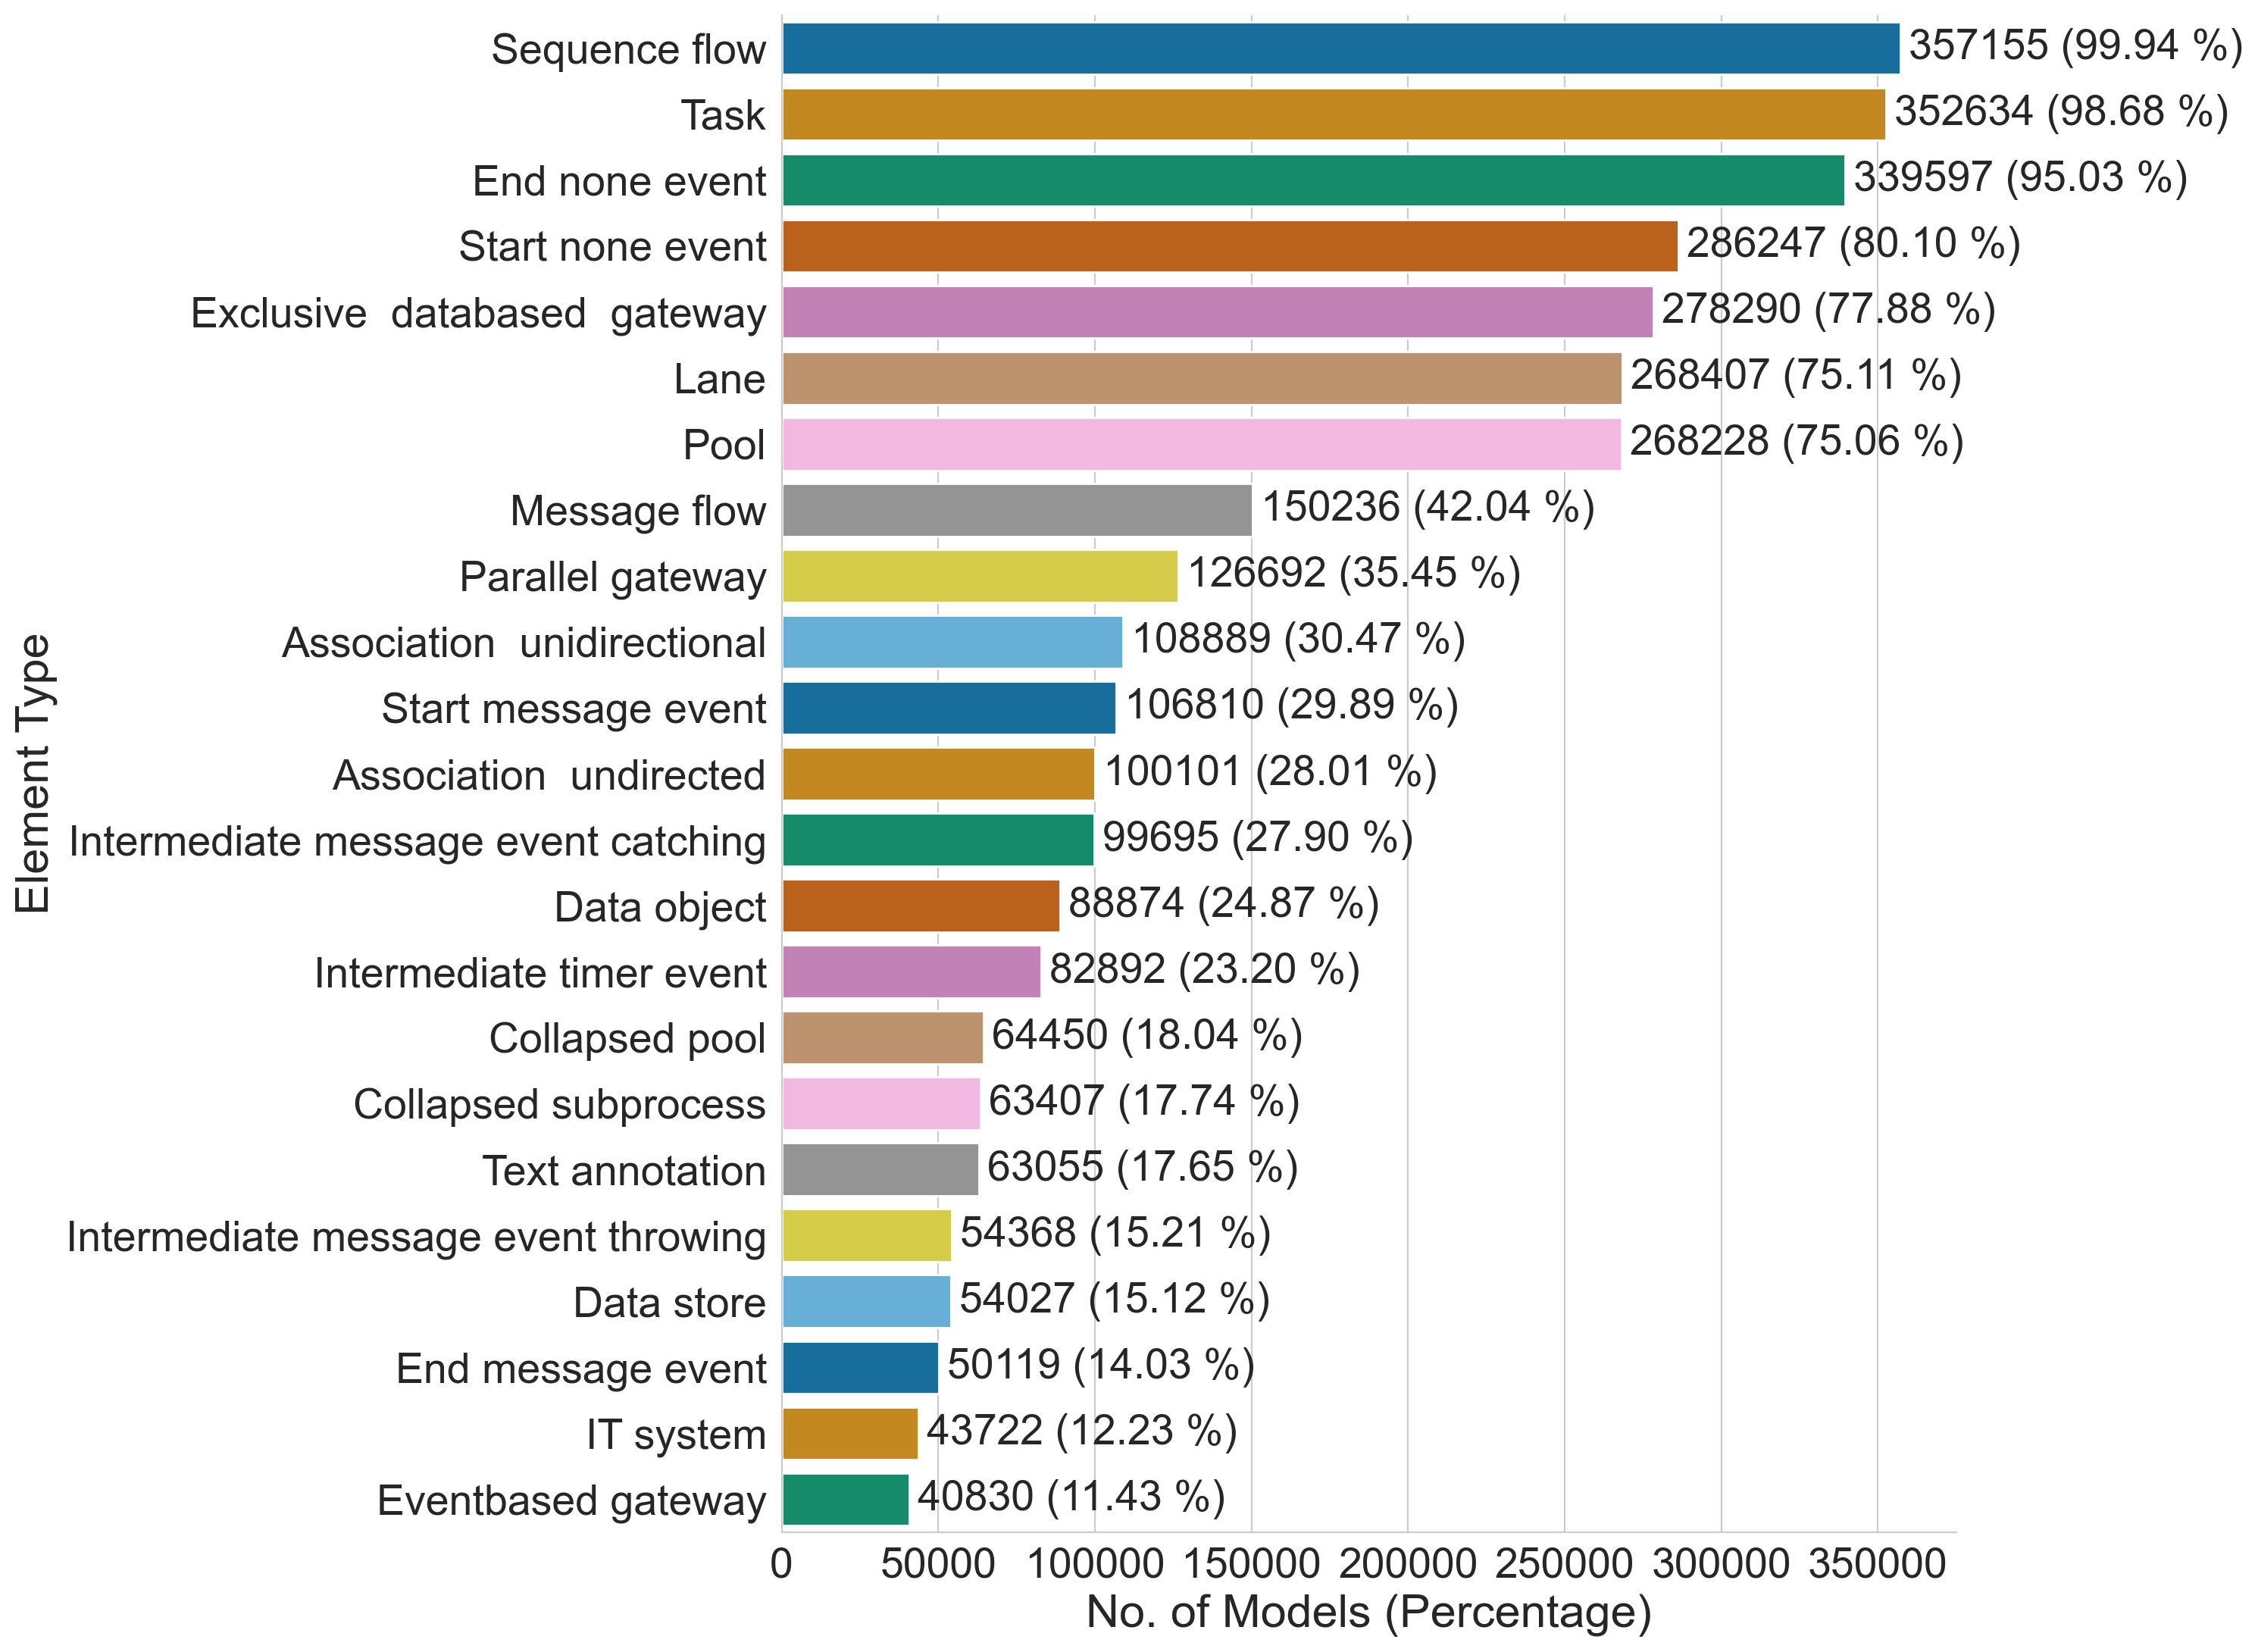

In [49]:
plt.figure(figsize=(10,13)) # 10,13
plt.rcParams.update({'font.size': 20}) # 22
containers_nb = df_freq['category'].nunique()
# for running analysis on smaller datasets, the hue setting must be omitted, otherwise graph won't be created.
# reason: number of containers represents the original overall count of categories (from the first dataframe), not the filtered/manipulated ones. As a result, more containers are being iterated over as should be.
# thoroughly investigated and origin of problem currently unknown.
if len(df_meta_bpmn) > 4000: # arbitrary value
    ax = sns.barplot(x="frequency", y="category",hue="category", legend=False, data=df_freq, order=df_freq.sort_values('frequency',ascending=False).category,palette=sns.color_palette("colorblind", n_colors=containers_nb))
else:
    ax = sns.barplot(x="frequency", y="category",data=df_freq, order=df_freq.sort_values('frequency',ascending=False).category,palette=sns.color_palette("colorblind", n_colors=containers_nb))
total = len(df_cnts)
labels = [f'{val} ({val / total * 100.0:.2f} %)' for val in df_freq['frequency']]
for container, label in zip(ax.containers, labels):
    ax.bar_label(container, label_type='edge', padding=4, labels=[label])
ax.set_xlabel("No. of Models (Percentage)",fontsize=22)
ax.set_ylabel("Element Type",fontsize=22)
sns.despine()
plt.savefig(constants.FIGURES_ROOT / 'elements_usage.pdf',transparent=True,bbox_inches = 'tight')

# Business objects

Now, let's take a look at business objects in BPMN 2.0 diagrams, also known as dictionary items or glossary entries. The dictionary is a Signavio feature that allows the user to enable reusability of BPMN diagram elements by dragging them out of a list, instead of having to recreate them for each diagram. That way, the creation of diagrams is made less time consuming, while also ensuring name and attributes consistency for elements that are recurrent through an organisation's processes (for example, IT system).

In [50]:
df_bpmn.head()

category  \
model_id                         element_id                                               
0000150e890c45928d26584d491ada68 sid-534315D0-DCAD-4BDB-A855-DC3CFDA5EE27  SequenceFlow   
                                 sid-58A29CA7-DE25-4BCC-B8EF-7AA5F72DB725  SequenceFlow   
                                 sid-1C9E3326-48BD-464F-B112-0C7523C2FCD3  SequenceFlow   
                                 sid-A1C57CBC-95F6-49D0-B7CE-EAC914FF86A8  SequenceFlow   
                                 sid-50E32FDE-0432-4404-97E2-18193BC74EAC  SequenceFlow   

                                                                                                                label  \
model_id                         element_id                                                                             
0000150e890c45928d26584d491ada68 sid-534315D0-DCAD-4BDB-A855-DC3CFDA5EE27                                               
                                 sid-58A29CA7-DE25-4BCC-B8EF-7AA5F72DB725                                               
                                 sid-1C9E3326-48BD-464F-B112-0C7523C2FCD3                                               
                                 sid-A1C57CBC-95F6-49D0-B7CE-EAC914FF86A8       CredibilityAssessment IN {rejected}\n   
                                 sid-50E32FDE-0432-4404-97E2-18193BC74EAC  CheckedCredibilityAssessment IN {accepted}   

                                                                          glossary_link_id  \
model_id                         element_id                                                  
0000150e890c45928d26584d491ada68 sid-534315D0-DCAD-4BDB-A855-DC3CFDA5EE27             None   
                                 sid-58A29CA7-DE25-4BCC-B8EF-7AA5F72DB725             None   
                                 sid-1C9E3326-48BD-464F-B112-0C7523C2FCD3             None   
                                 sid-A1C57CBC-95F6-49D0-B7CE-EAC914FF86A8             None   
                                 sid-50E32FDE-0432-4404-97E2-18193BC74EAC             None   

                                                                          name  
model_id                         element_id                                     
0000150e890c45928d26584d491ada68 sid-534315D0-DCAD-4BDB-A855-DC3CFDA5EE27  P5   
                                 sid-58A29CA7-DE25-4BCC-B8EF-7AA5F72DB725  P5   
                                 sid-1C9E3326-48BD-464F-B112-0C7523C2FCD3  P5   
                                 sid-A1C57CBC-95F6-49D0-B7CE-EAC914FF86A8  P5   
                                 sid-50E32FDE-0432-4404-97E2-18193BC74EAC  P5

First, we calculate and visualize the total counts of business objects in the dataset.

In [51]:
total_bos = df_bpmn[(df_bpmn['glossary_link_id'] != "") & (df_bpmn['glossary_link_id'] != "None")]

This give us a total count of:

In [52]:
total_bos_count = len(total_bos)
total_bos_count

143531

In [53]:
len(df_bpmn)

18918360

When compared to the total number of elements, that would be about:

In [54]:
print(f"{round(total_bos_count/len(df_bpmn)*100, 2)}%")

0.76%


Next, let's take a look at how many models have at least one glossary link.

In [55]:
models_w_bos = df_bpmn[(df_bpmn['glossary_link_id'] != "") 
    & (df_bpmn['glossary_link_id'] != "None")].groupby(level=['model_id']).size()

This is the number of models with at least one element from the dictionary:

In [56]:
len(models_w_bos)

43817

The highest number of glossary links used in one model:

In [57]:
models_w_bos.max()

457

Now, let's take a look at how many unique glossary items are present in the dataset, and compare it to the overall count.

In [58]:
unique_bo_ids_count = len(df_bpmn['glossary_link_id'].unique())
unique_bo_ids_count

42750

In [59]:
print(f"{round(unique_bo_ids_count/total_bos_count*100, 2)}%")

29.78%


This is the percentage of unique glossary items in the dataset. In other terms, it gives us a rough idea of how often dictionary items are being reused in the models.

We also want to find out what is the most used type of dictionary item. For that, we create a plot:

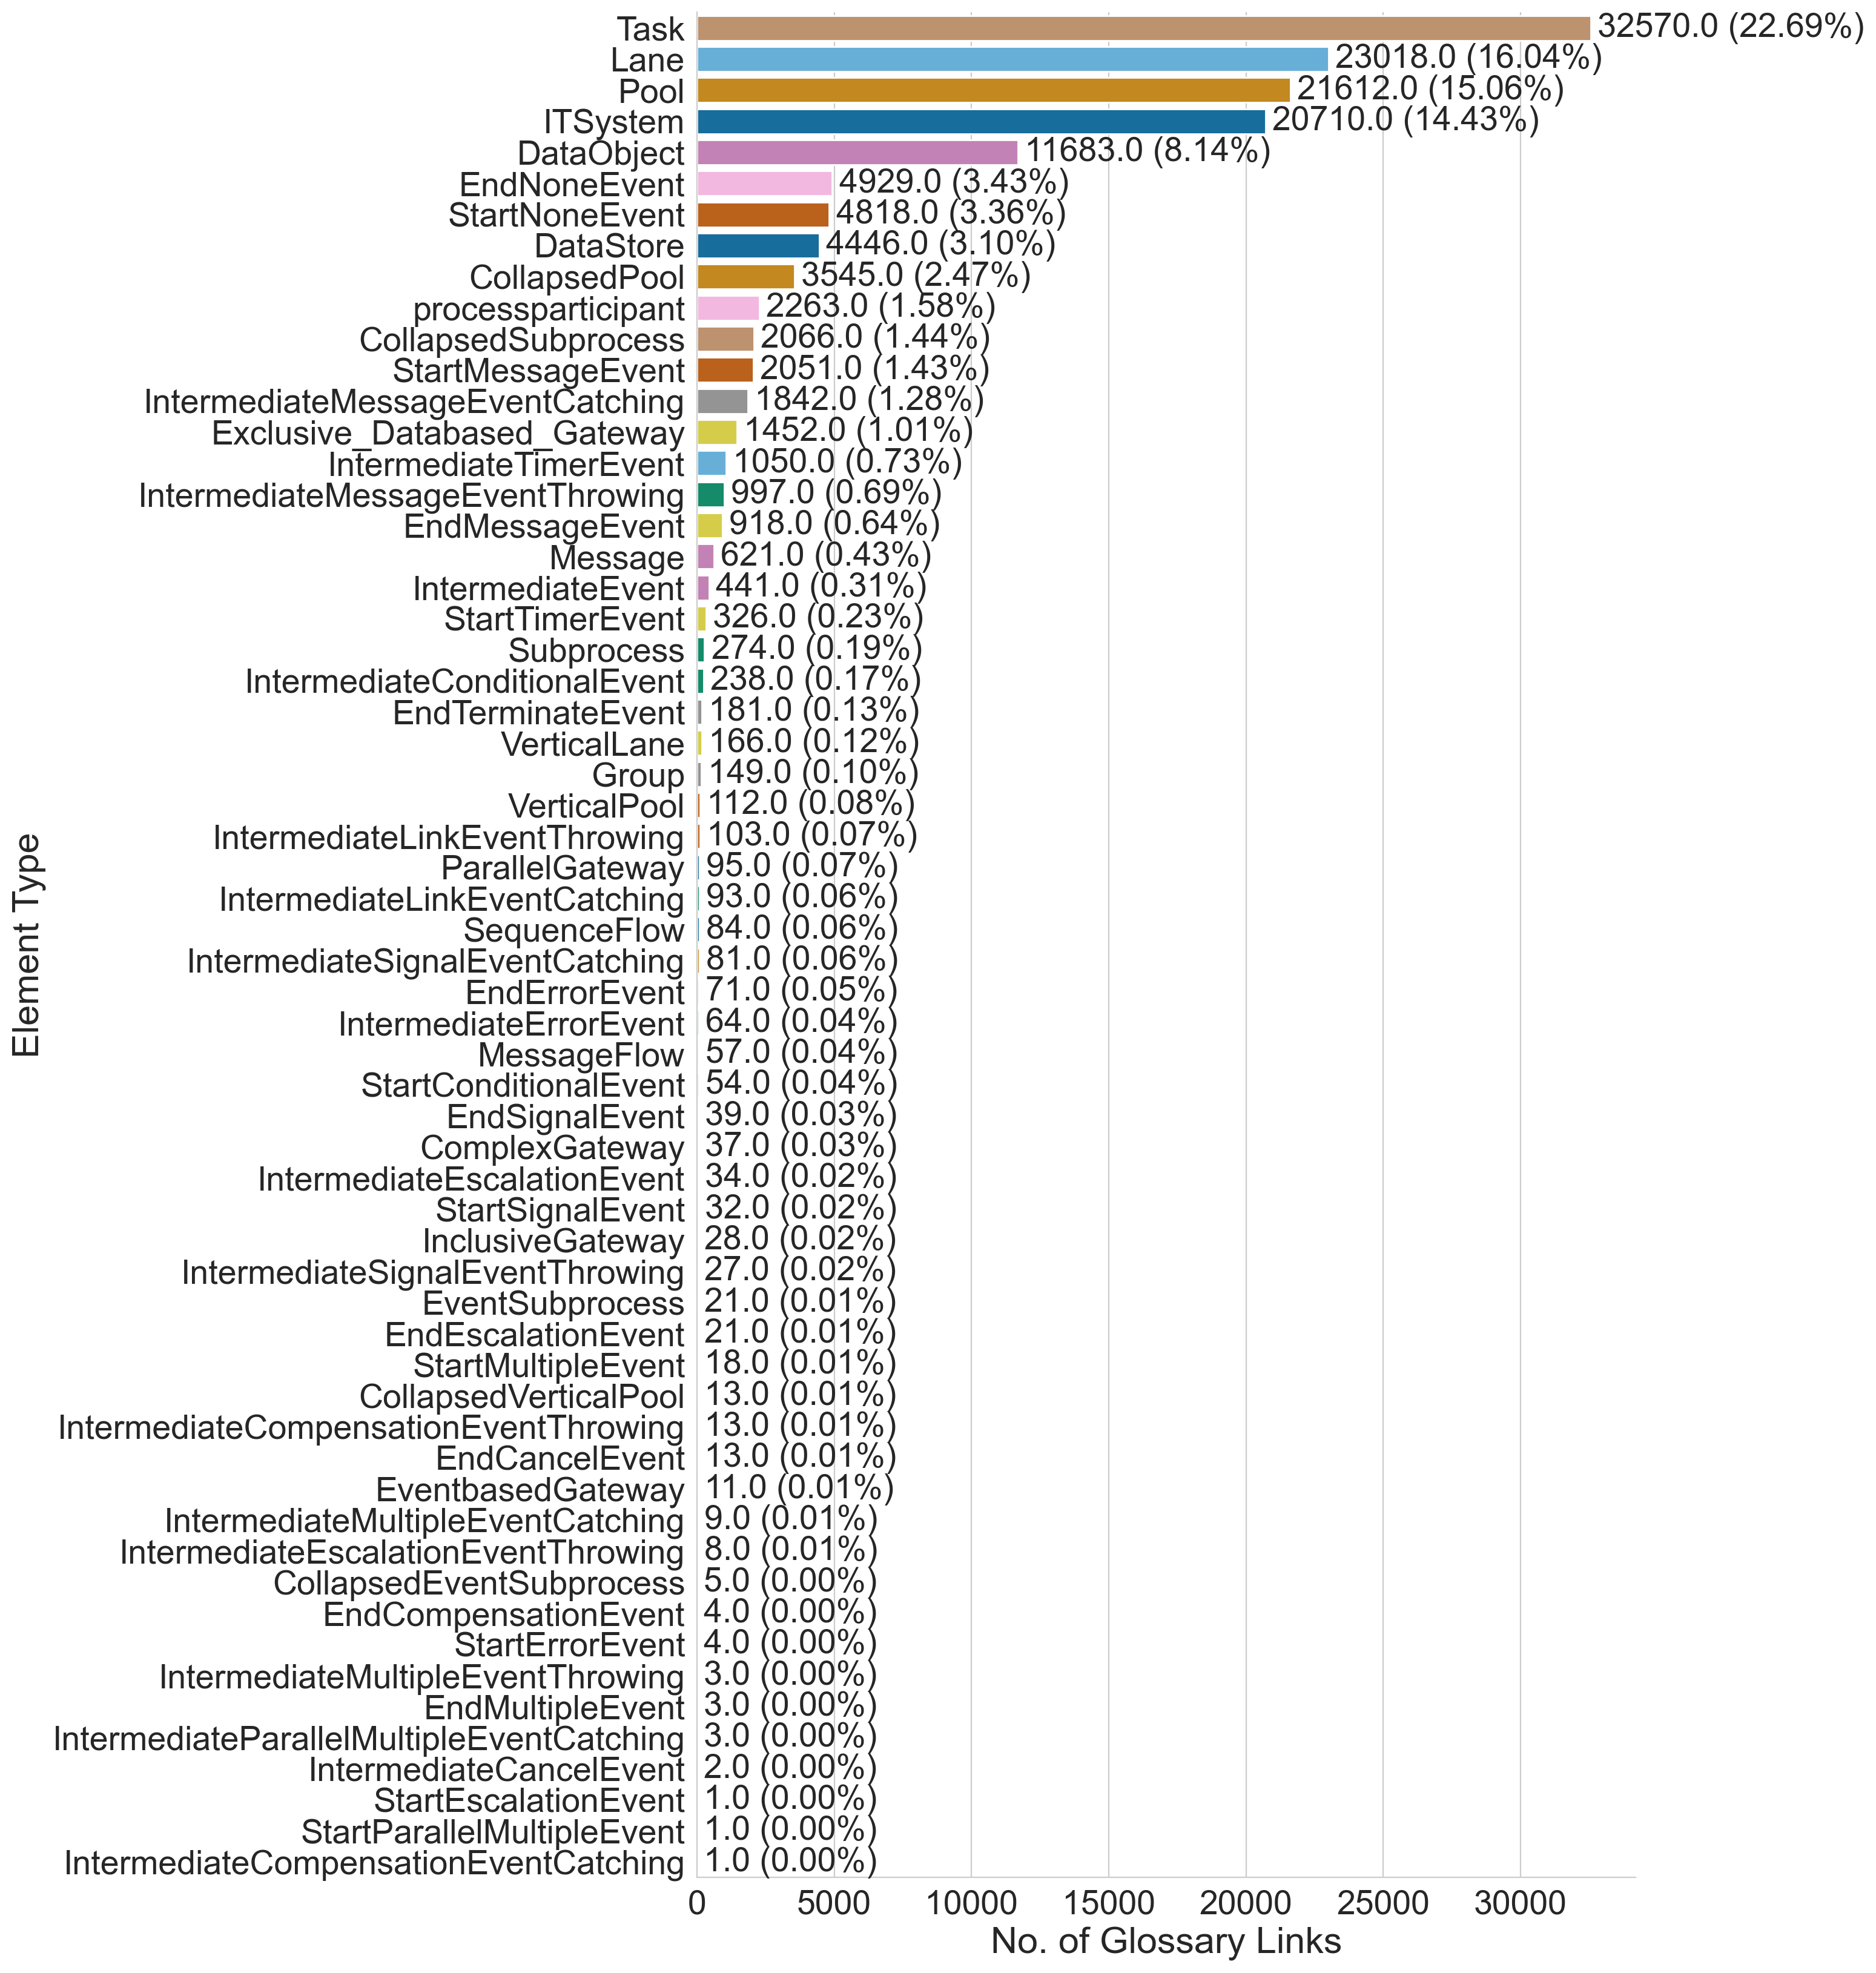

In [60]:
plt.figure(figsize=(10,20))
plt.rcParams.update({'font.size': 20})
containers_nb = total_bos['category'].nunique()
total_bos.loc[:, 'category'] = total_bos['category'].astype('category').cat.remove_unused_categories()
#total_bos.loc[:, 'category'] = total_bos['category'].cat.remove_unused_categories()
# for running analysis on smaller datasets, the hue setting must be omitted, otherwise graph won't be created.
# reason: number of containers represents the original overall count of categories (from the first dataframe), not the filtered/manipulated ones. As a result, more containers are being iterated over as should be.
# thoroughly investigated and origin of problem currently unknown.
if len(df_meta_bpmn) > 4000: # arbitrary value
    ax = sns.countplot(y="category", hue="category", data=total_bos, order=total_bos['category'].value_counts().index,palette=sns.color_palette("colorblind", n_colors=containers_nb),legend=False)
else:
    ax = sns.countplot(y="category", data=total_bos, order=total_bos['category'].value_counts().index,palette=sns.color_palette("colorblind", n_colors=containers_nb))
labels = []
for container in ax.containers:
    for val in container:
        labels.append(f'{val.get_width()} ({val.get_width()/total_bos_count*100.0:.2f}%)')
for container, label in zip(ax.containers, labels):
    ax.bar_label(container, label_type='edge', padding=4, labels=[label])
sns.despine()
ax.set_xlabel("No. of Glossary Links",fontsize=22)
ax.set_ylabel("Element Type",fontsize=22)
plt.savefig(constants.FIGURES_ROOT / 'glossary_elements_usage.pdf',transparent=True,bbox_inches = 'tight')

For the next analysis, let's concentrate on one particular category, 'ITSystem'. First, let's see how many models with 'ITSystem' entries we have in the dataset. In this way, we can evaluate how many different IT systems a process model is using.

In [61]:
its_bos = total_bos[total_bos['category'] == 'ITSystem']
its_bos = its_bos.reset_index()
its_bos_count = its_bos.groupby('model_id')['glossary_link_id'].count().reset_index()

This is the count of models using at least one dictionary item of type 'ITSystem' in the dataset.

In [62]:
len(its_bos_count)

8811

Let's plot the distribution of these glossary entries across models. For the sake of readability, we aggregate all models using more than 7 IT Systems elements in the 'Other' category.

In [63]:
its_count_per_model = its_bos_count['glossary_link_id'].value_counts().sort_index()
its_count_per_model.index = its_count_per_model.index.where(its_count_per_model.index < 8, '8+')
its_count_per_model = its_count_per_model.groupby(its_count_per_model.index).sum()

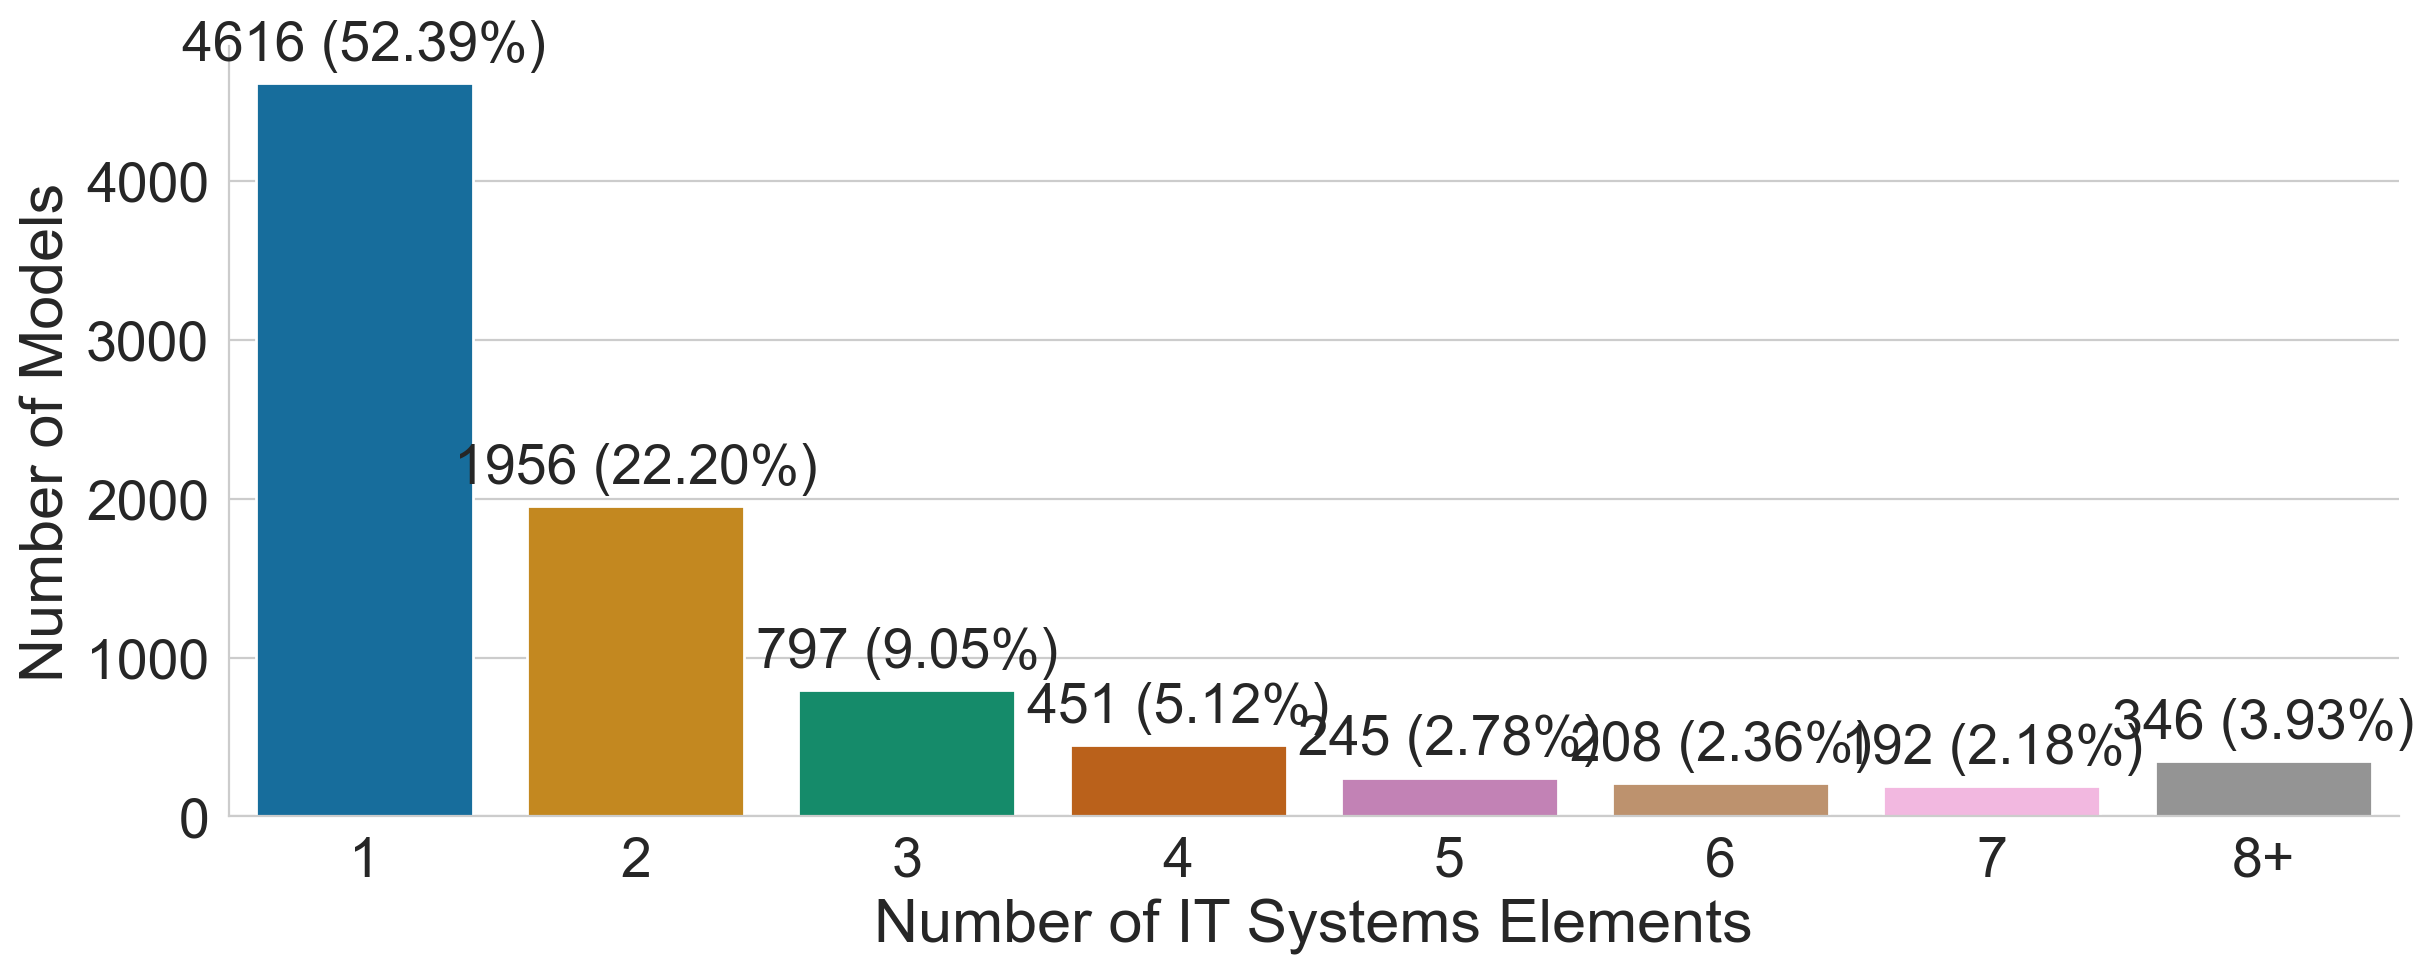

In [64]:
if len(its_bos_count) == 0:
    pass
else:
    plt.figure(figsize=(14, 5))
    containers_nb = its_count_per_model.index.nunique()
    ax = sns.barplot(x=its_count_per_model.index,y=its_count_per_model.values,hue=its_count_per_model.index,palette=sns.color_palette("colorblind",n_colors=containers_nb),legend=False)
    total = len(its_bos_count)
    labels = [f'{val} ({val/total*100.0:.2f}%)' for val in its_count_per_model.values]
    for container, label in zip(ax.containers, labels):
        ax.bar_label(container, label_type='edge', padding=4, labels=[label])
    sns.despine()
    ax.set_xlabel("Number of IT Systems Elements",fontsize=22)
    ax.set_ylabel("Number of Models",fontsize=22)
    plt.savefig(constants.FIGURES_ROOT / 'distribution_itsystems.pdf',transparent=True,bbox_inches = 'tight')

Now, let's see how many of these IT Systems might in fact be referring to the same item, but involved at different stages of the process modelling.

In [65]:
its_bos = its_bos.groupby('model_id')['glossary_link_id'].nunique().reset_index()
its_count_per_model = its_bos['glossary_link_id'].value_counts().sort_index()
its_count_per_model.index = its_count_per_model.index.where(its_count_per_model.index < 8, '8+')
its_count_per_model = its_count_per_model.groupby(its_count_per_model.index).sum()

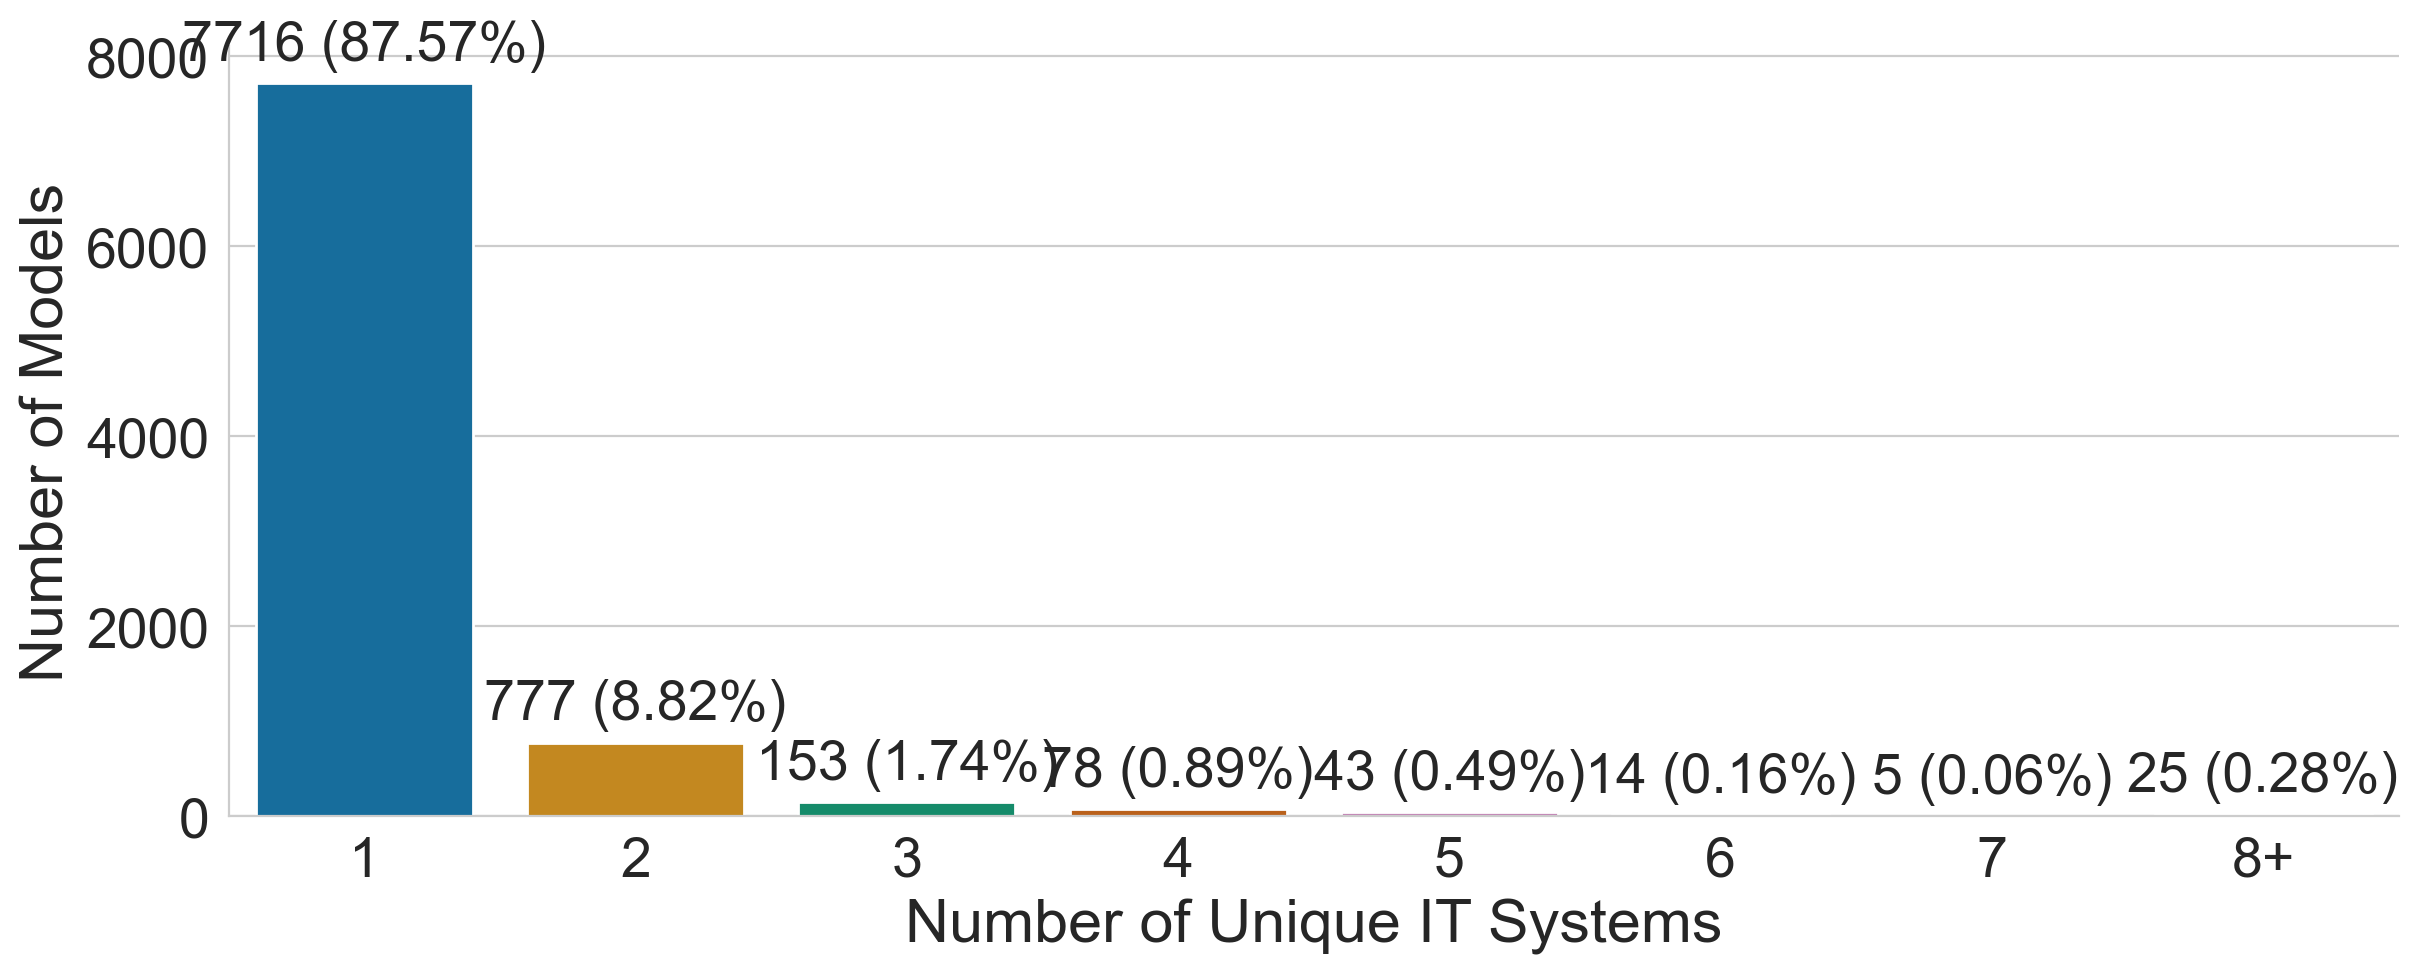

In [66]:
if len(its_bos_count) == 0:
    pass
else:
    plt.figure(figsize=(14, 5))
    containers_nb = its_count_per_model.index.nunique()
    ax = sns.barplot(x=its_count_per_model.index,y=its_count_per_model.values,hue=its_count_per_model.index,palette=sns.color_palette("colorblind",n_colors=containers_nb),legend=False)
    total = len(its_bos)
    labels = [f'{val} ({val/total*100.0:.2f}%)' for val in its_count_per_model.values]
    for container, label in zip(ax.containers, labels):
        ax.bar_label(container, label_type='edge', padding=4, labels=[label])
    sns.despine()
    ax.set_xlabel("Number of Unique IT Systems",fontsize=22)
    ax.set_ylabel("Number of Models",fontsize=22)
    plt.savefig(constants.FIGURES_ROOT / 'distribution_unique_itsystems.pdf',transparent=True,bbox_inches = 'tight')

As expected, we can observe that an overwhelming majority of models is using only one IT System, regardless of the number of times it is involved in a single process model.

# Elements

These are the statistics of the number of elements per model:

In [67]:
cnt_elements.total_count.describe()

count     357352.0
mean     52.940406
std      51.585116
min            5.0
25%           24.0
50%           41.0
75%           65.0
max         3939.0
Name: total_count, dtype: Float64

These are the statistics of the number of elements per model by element type:

In [68]:
cnt_elements.describe().transpose().head()

count       mean        std  min  25%   50%   75%     max
SequenceFlow  357352.0  20.977193  19.874243  0.0  9.0  16.0  26.0  2060.0
Pool          357352.0   1.194662   1.107892  0.0  1.0   1.0   2.0    33.0
Lane          357352.0    2.16622   2.021225  0.0  1.0   2.0   3.0   149.0
Task          357352.0    9.88593   9.614485  0.0  4.0   8.0  13.0  1543.0
EndNoneEvent  357352.0   1.901881   1.734901  0.0  1.0   1.0   2.0    92.0

The above table is quite large, therefore we summarize it by aggregating the element types to groups and categories as given by the Signavio BPMN 2.0 stencil set specification.

In [69]:
d_low_level_mapping = mappings["element_type_low_level"] # groups
d_high_level_mapping = mappings["element_type_high_level"] # categories

Let's first have a look at the lower level aggregation (groups of similar element types):

In [70]:
df_low_level = cnt_elements.groupby(by=d_low_level_mapping,axis=1).sum()
df_stats = df_low_level.describe().transpose()
df_stats

/var/folders/rn/8_jypvhj2jv1m35k5h8ygpyh0000gn/T/ipykernel_60059/2650037200.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_low_level = cnt_elements.groupby(by=d_low_level_mapping,axis=1).sum()


count       mean        std  min   25%   50%   75%  \
Activities          357352.0  10.448278   9.879828  1.0   5.0   8.0  13.0   
Artifacts           357352.0   1.049702   5.003785  0.0   0.0   0.0   1.0   
Connecting Objects  357352.0  26.054392  27.140328  0.0  11.0  19.0  32.0   
Data Elements       357352.0   1.461592    4.29009  0.0   0.0   0.0   1.0   
Events              357352.0   5.847061   6.335194  2.0   2.0   4.0   7.0   
Gateways            357352.0   4.389384   5.367716  0.0   2.0   3.0   6.0   
Swimlanes           357352.0   3.689981   3.100437  0.0   2.0   4.0   5.0   

                       max  
Activities          1543.0  
Artifacts            529.0  
Connecting Objects  2066.0  
Data Elements        266.0  
Events               157.0  
Gateways             303.0  
Swimlanes            227.0

In [71]:
df_stats.drop(columns=["count"],inplace=True)
df_stats = df_stats.round(1)
df_stats

mean   std  min   25%   50%   75%     max
Activities          10.4   9.9  1.0   5.0   8.0  13.0  1543.0
Artifacts            1.0   5.0  0.0   0.0   0.0   1.0   529.0
Connecting Objects  26.1  27.1  0.0  11.0  19.0  32.0  2066.0
Data Elements        1.5   4.3  0.0   0.0   0.0   1.0   266.0
Events               5.8   6.3  2.0   2.0   4.0   7.0   157.0
Gateways             4.4   5.4  0.0   2.0   3.0   6.0   303.0
Swimlanes            3.7   3.1  0.0   2.0   4.0   5.0   227.0

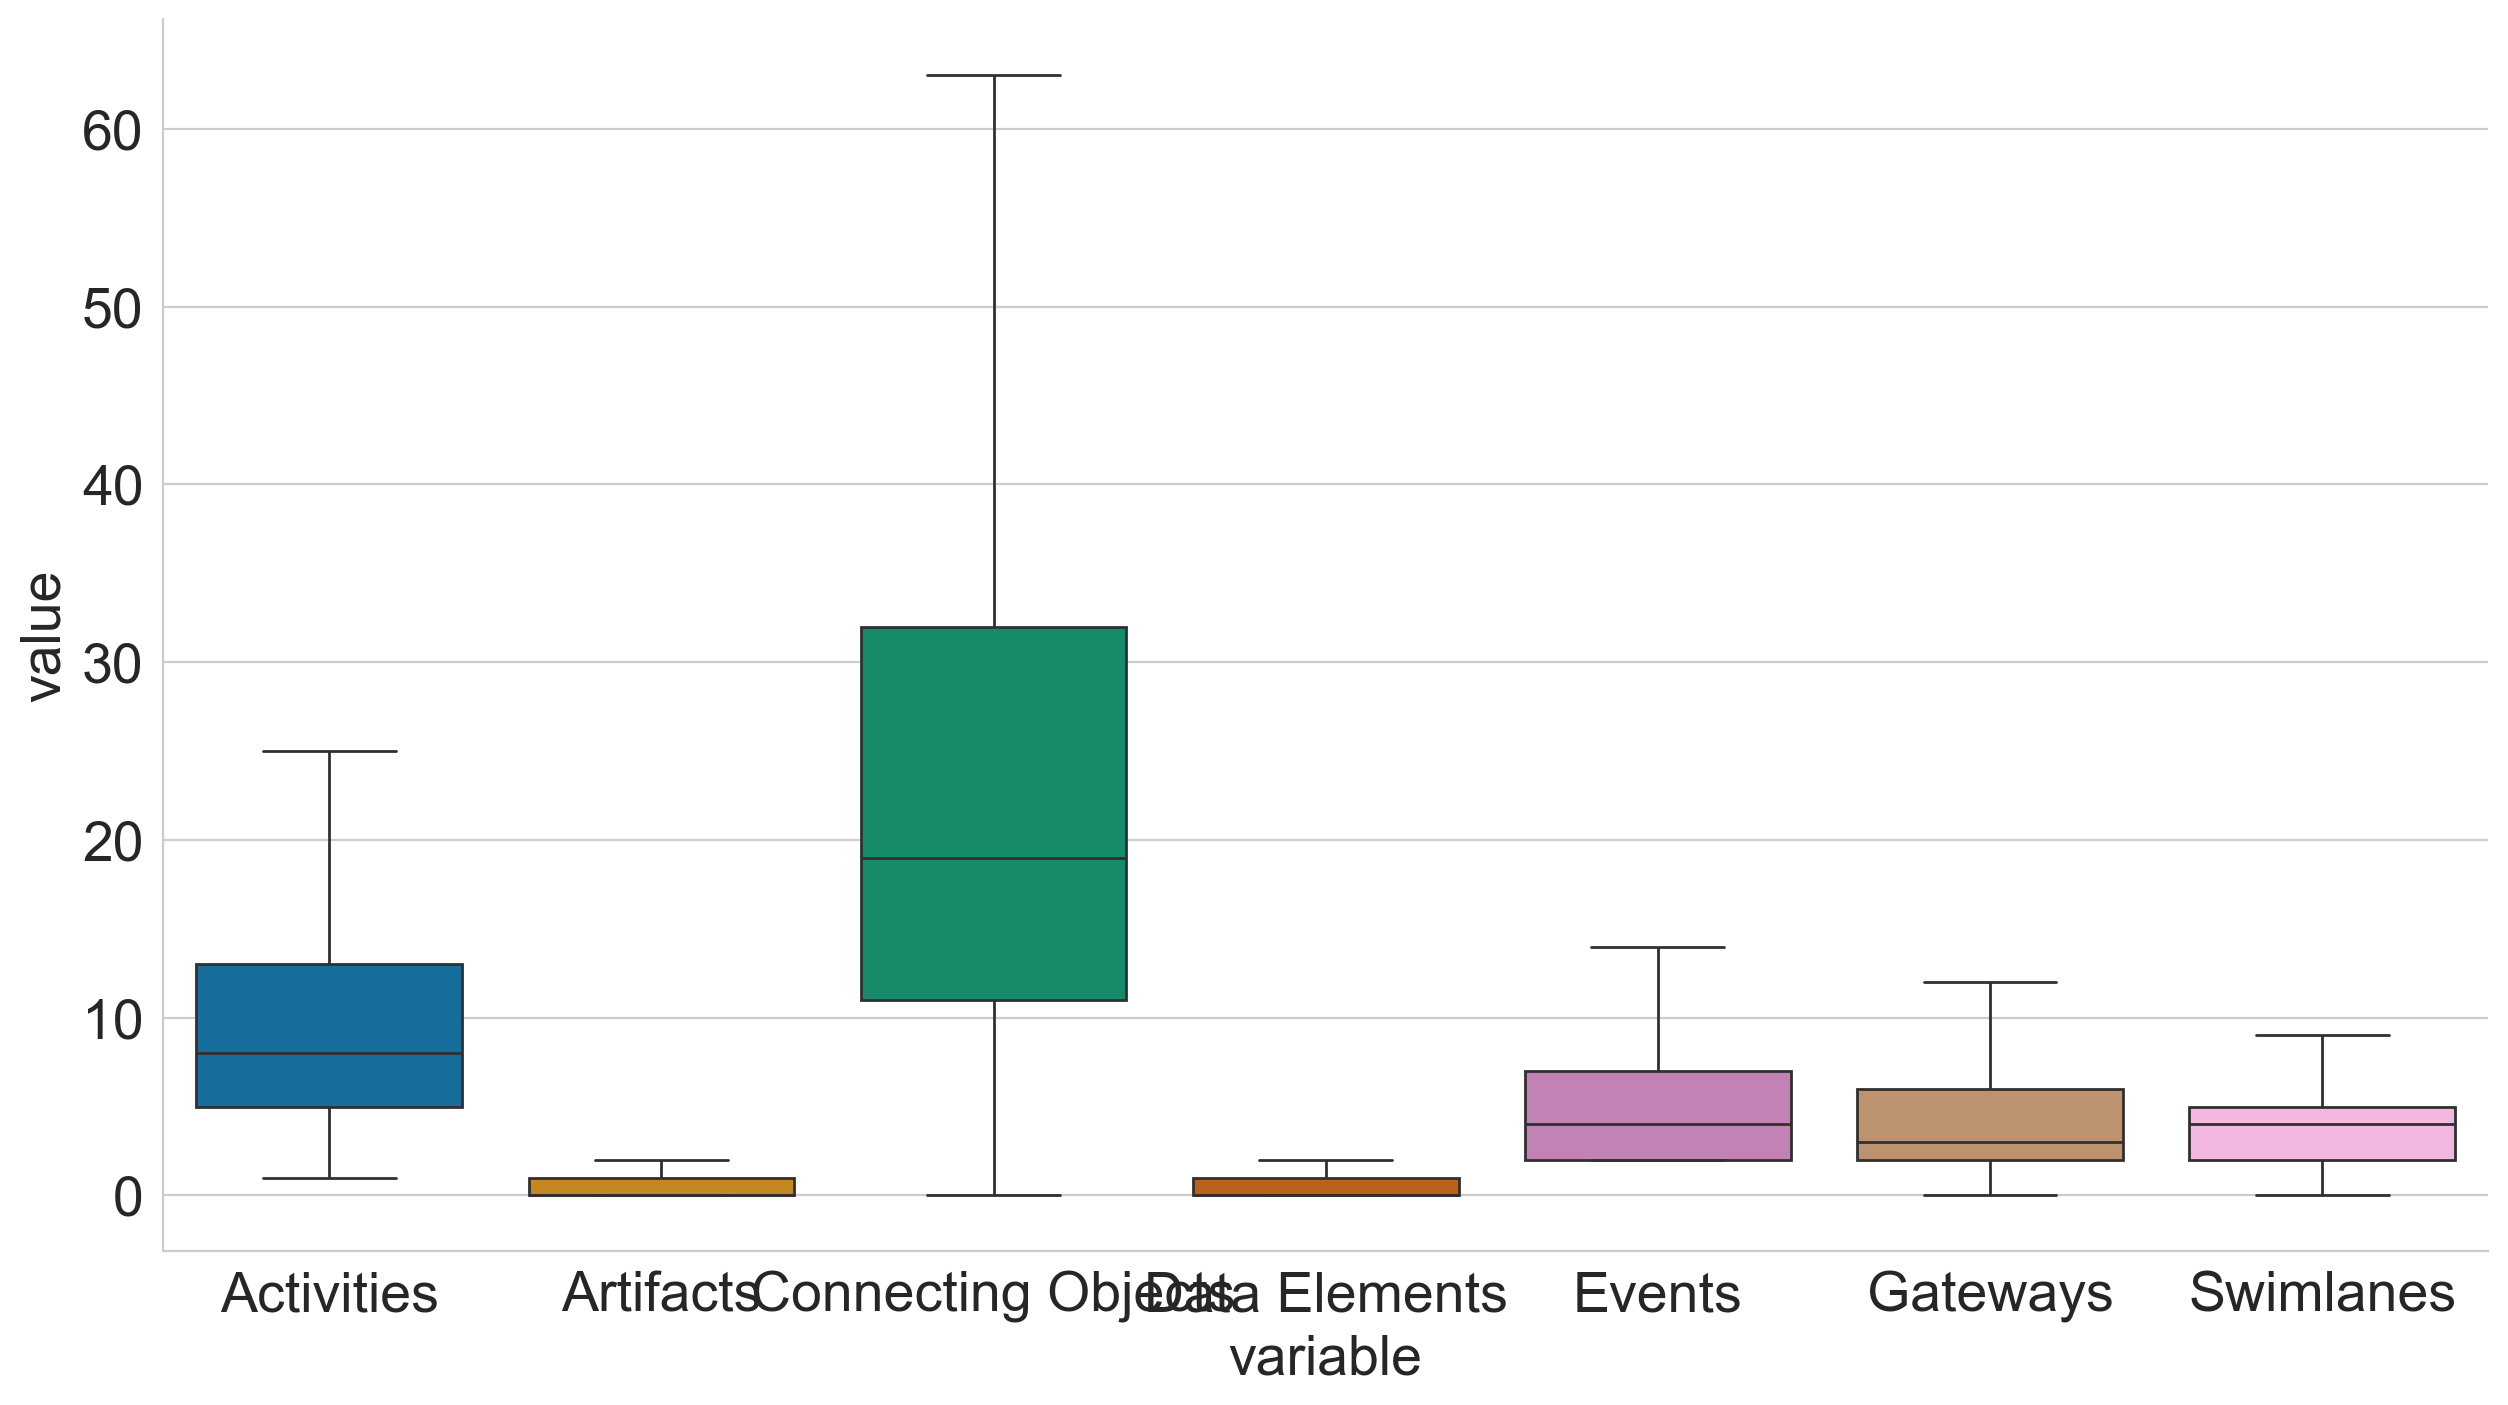

In [72]:
plt.figure(figsize=(15,8))
df_low_level["id"] = df_low_level.index
df_low_level_long = pd.melt(df_low_level, id_vars='id', value_vars=['Activities', 'Artifacts', 'Connecting Objects', 'Data Elements', 'Events', 'Gateways', 'Swimlanes'])
ax=sns.boxplot(x="variable", y="value", hue="variable", legend=False, data=df_low_level_long,showfliers=False,palette=sns.color_palette("colorblind", n_colors=7))
#ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
sns.despine()

Now, let's also have a look at a higher level aggregation (categories: nodes and edges).

In [73]:
df_high_level = cnt_elements.groupby(by=d_high_level_mapping,axis=1).sum()
df_high_level.rename(columns={"edge": "No. of Edges", "node": "No. of Nodes"},inplace=True)
df_high_level.describe().transpose()

/var/folders/rn/8_jypvhj2jv1m35k5h8ygpyh0000gn/T/ipykernel_60059/1799829117.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_high_level = cnt_elements.groupby(by=d_high_level_mapping,axis=1).sum()


count       mean        std  min   25%   50%   75%     max
No. of Edges  357352.0  26.054392  27.140328  0.0  11.0  19.0  32.0  2066.0
No. of Nodes  357352.0  26.885998  24.664298  3.0  13.0  21.0  33.0  1873.0

In [74]:
df_high_level.head()

No. of Edges  No. of Nodes
0            28            32
1             8             8
2            16            20
3            57            65
4            60            49

The number of nodes and edges is naturally highly correlated:

<Figure size 500x500 with 0 Axes>

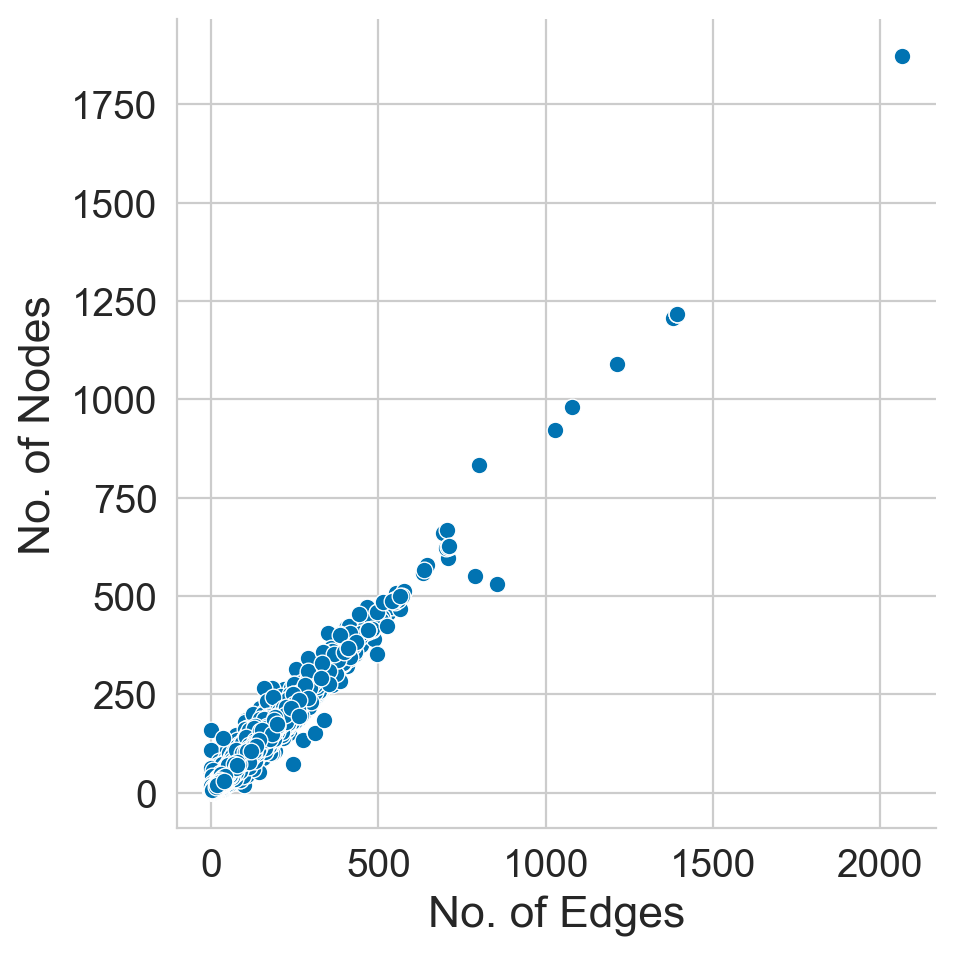

In [75]:
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 14,'axes.labelsize': 16})
ax = sns.relplot(data=df_high_level.astype(float), x = "No. of Edges", y = "No. of Nodes",color=sns.color_palette("colorblind",as_cmap=True)[0])
sns.despine()
#plt.savefig(constants.FIGURES_ROOT / 'correl_plot.png',transparent=True,bbox_inches = 'tight',dpi=300)
plt.savefig(constants.FIGURES_ROOT / 'correl_plot.pdf',transparent=True,bbox_inches = 'tight')

# Process names 

Let's now have a look at the process names.

A function for cleaning the names or labels (if required for the use case):

In [76]:
def clean(label):
    # handle some special cases
    label = label.replace("\n", " ").replace("\r", "")
    label = label.replace("(s)", "s")
    # turn any non alphanumeric characters into whitespace
    # label = re.sub("[^A-Za-z]"," ",label)
    # delete unnecessary whitespaces
    label = label.strip()
    label = re.sub("\s{1,}"," ",label)
    # make all lower case
    label = label.lower()
    return label

def alphanumeric(label):
    return re.sub("[^A-Za-z]"," ",label)

In [77]:
cnts_names = dict(Counter(df_meta['name'].values))
#cnts_names = dict(Counter(df_meta['name'].apply(lambda x: clean(str(x))).values))
cnts_names = pd.DataFrame.from_dict(cnts_names.items())
cnts_names.columns = ['name', 'occurrences']
cnts_names = cnts_names.sort_values(by=['occurrences'],ignore_index=True,ascending=False)
cnts_names.head(10)

name  occurrences
0            12345678        24296
1         New Process        13268
2       Neuer Prozess         4756
3       12345678_rev1         2494
4       12345678_rev2         1530
5            Jane Doe         1351
6         New Diagram         1218
7       12345678_rev3         1118
8  New Process (Copy)          746
9       12345678_rev4          745

The number of distinct process names:

In [78]:
len(cnts_names)

328280

We use Signavio's color palette for the word cloud.

In [79]:
import random
colors = constants.COLORS_SIGNAVIO_HSL 
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(colors)

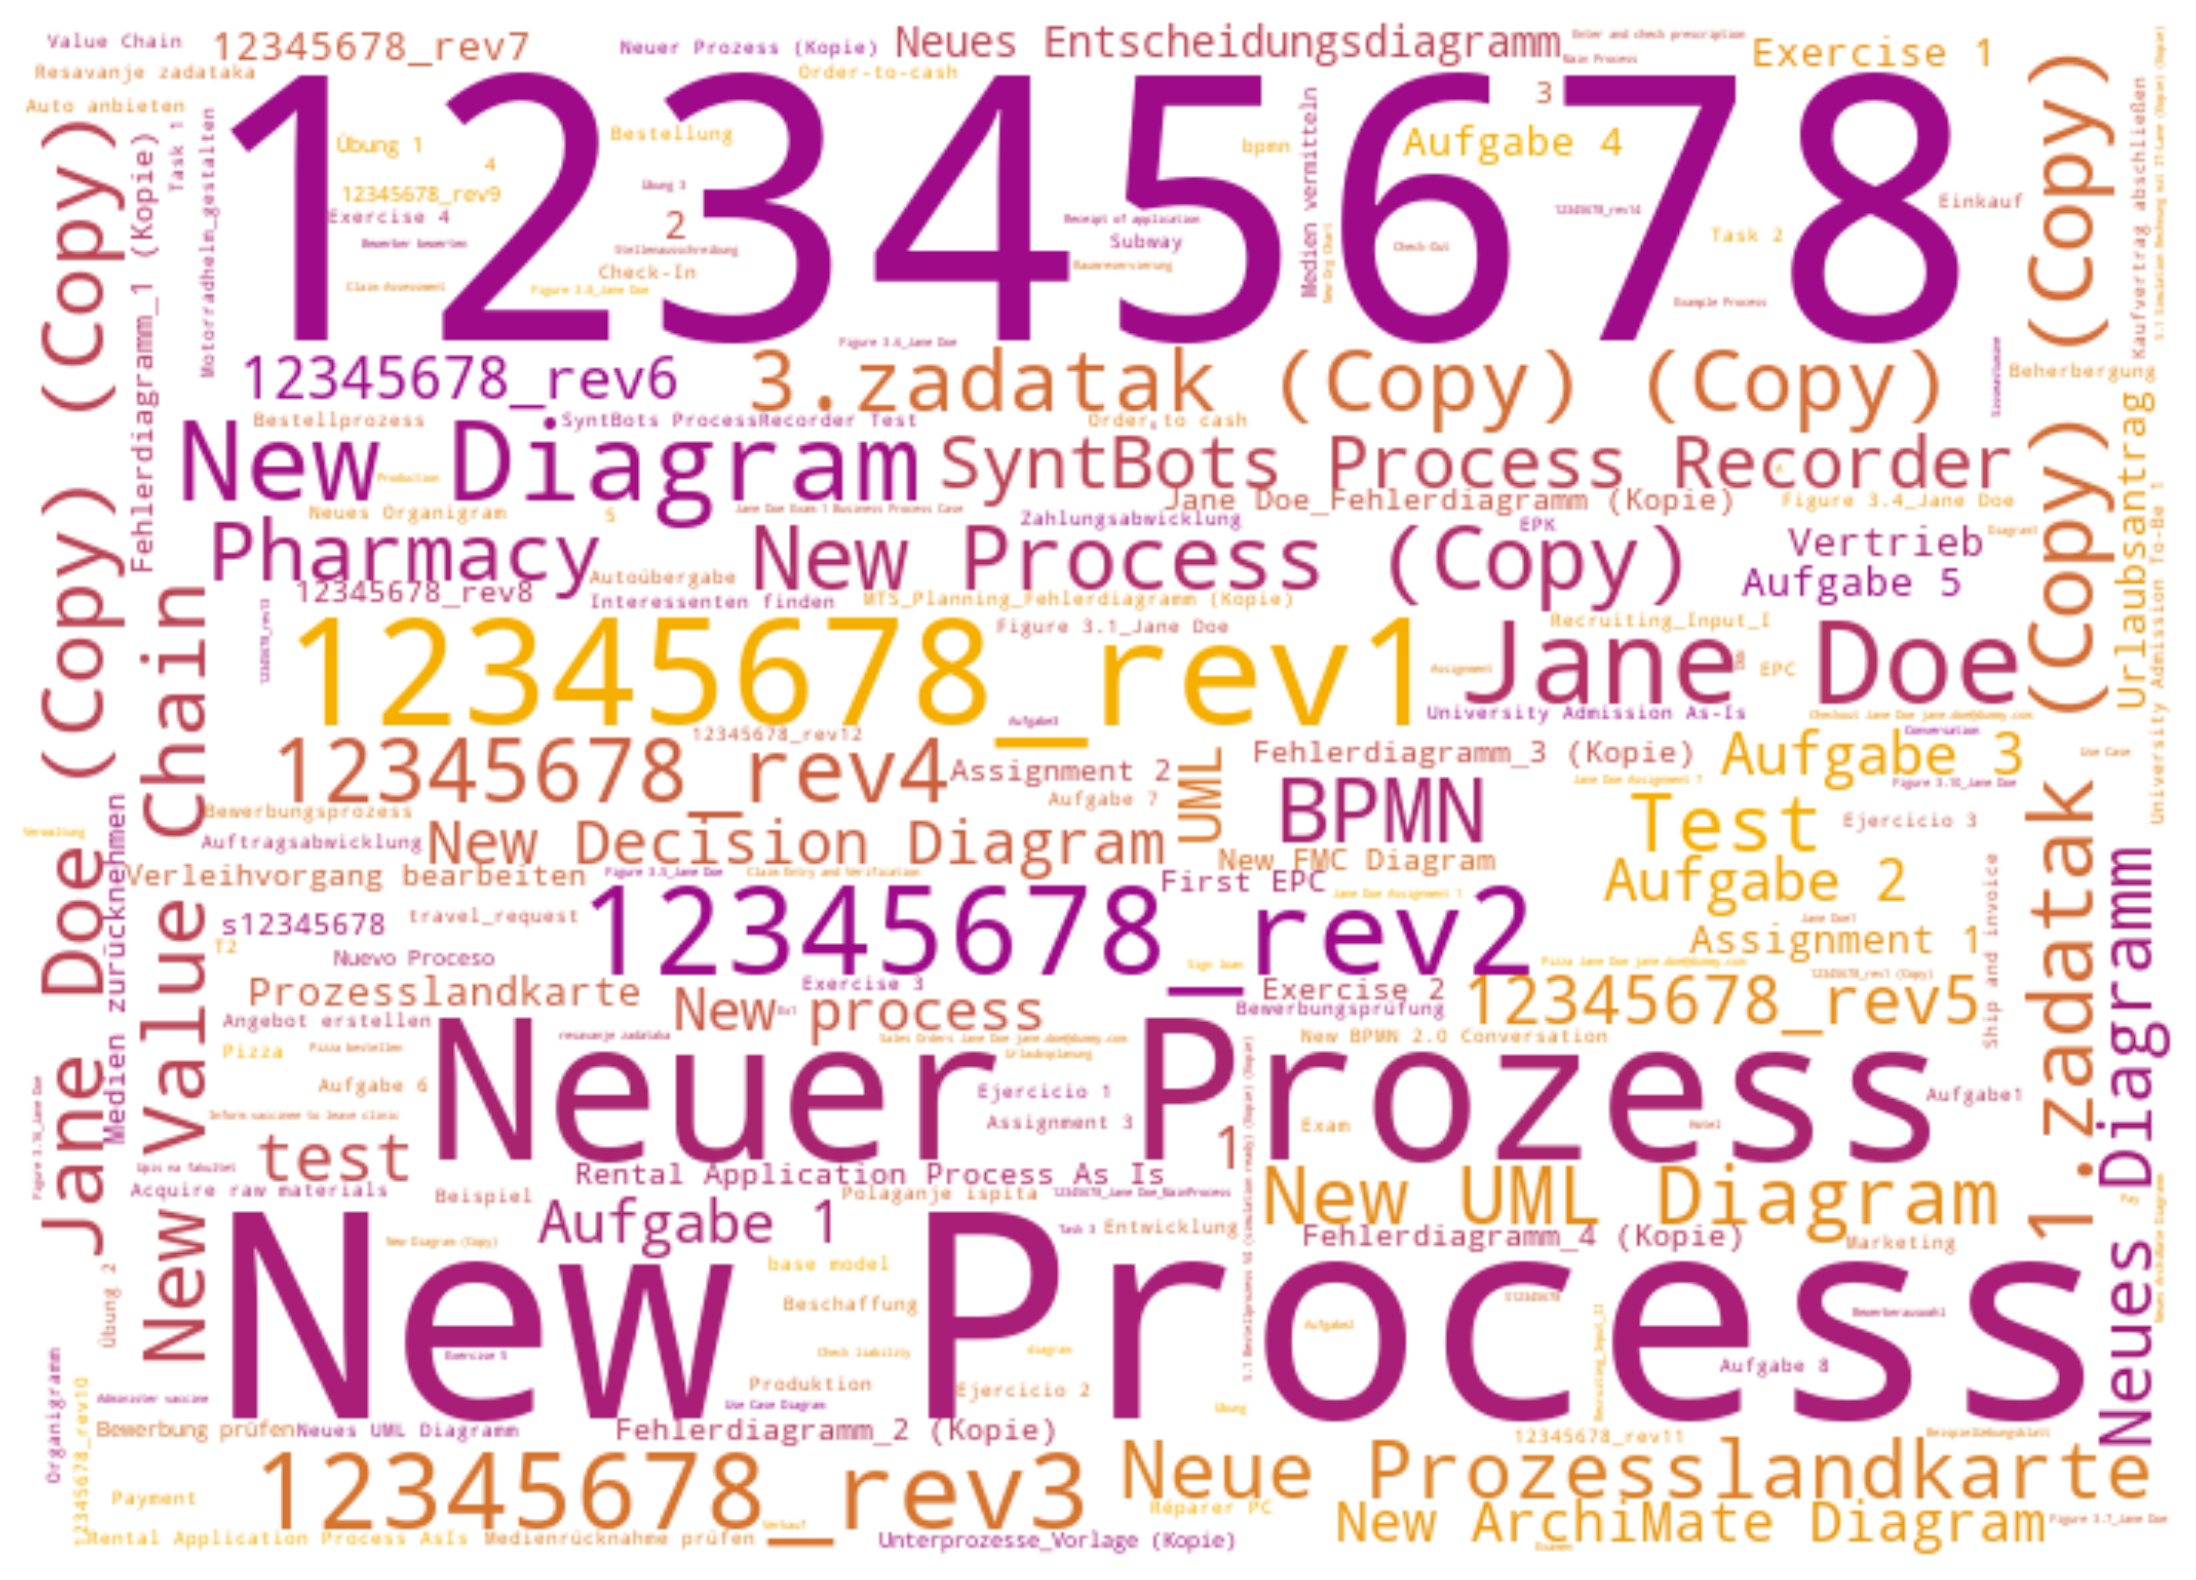

In [80]:
wordcloud_dict_names = dict(zip(cnts_names.name, cnts_names.occurrences))
wordcloud = WordCloud(min_word_length=1,background_color='white',width=700, height=500)
wordcloud = wordcloud.generate_from_frequencies(wordcloud_dict_names)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud.recolor(color_func = color_func), interpolation='bilinear')
plt.axis('off')
plt.savefig(constants.FIGURES_ROOT / 'word_cloud_process_names.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

It seems like the word cloud is dominated by the process names of the examples processes that are added to each newly created workspace.

# Labels

Let's also investigate element labels.

In [81]:
# cnts_labels = dict(Counter(df_bpmn['label'].apply(lambda x: clean(str(x))).values))
cnts_labels = dict(Counter(df_bpmn['label'].values))
cnts_labels = pd.DataFrame.from_dict(cnts_labels.items())
cnts_labels.columns = ['label', 'occurrences']
cnts_labels = cnts_labels.sort_values(by=['occurrences'],ignore_index=True,ascending=False)
cnts_labels = cnts_labels[~cnts_labels.label.isin([None,""])]
cnts_labels.reset_index(drop=True, inplace=True)
cnts_labels.head(10)

label  occurrences
0        No       112700
1       Yes        92294
2        Ja        47761
3        no        45817
4      Nein        44499
5       yes        37066
6        ja        36814
7      nein        36552
8  Customer        23762
9        NO        21192

The number of distinct element labels:

In [82]:
len(cnts_labels)

2687679

2.820.531 labels are used for the 28.293.762 elements in the BPMN models:

In [83]:
len(df_bpmn)

18918360

10 % of the unique labels make up for more than 74.0 % of the element labels ...

In [84]:
sum(cnts_labels.occurrences[:int(len(cnts_labels)*0.1)])/sum(cnts_labels.occurrences)

0.6187605395768804

... while 64.9 % of the labels are used for only one element.

In [85]:
len(cnts_labels[cnts_labels.occurrences==1])/len(cnts_labels)

0.6472655402672715

In [86]:
len(cnts_labels[cnts_labels.occurrences==1])

1739642

Let's visualize the distribution of the label usage frequency in BPMN 2.0 models.

In [87]:
bins = cnts_labels
bins.head()

label  occurrences
0    No       112700
1   Yes        92294
2    Ja        47761
3    no        45817
4  Nein        44499

We sort the labels based on their absolute usage frequency in descending order and group them in bins of size 10,000 to visualize the unevenness of the distribution.

In [88]:
N = 10000
bins = bins.groupby(bins.index // N).sum(numeric_only=True)

In [89]:
import math

bins["bins of labels"] = [N*i for i in range(1,math.ceil(len(cnts_labels)/N)+1)]
bins.head()

occurrences  bins of labels
0      2895808           10000
1       442786           20000
2       276067           30000
3       203896           40000
4       164511           50000

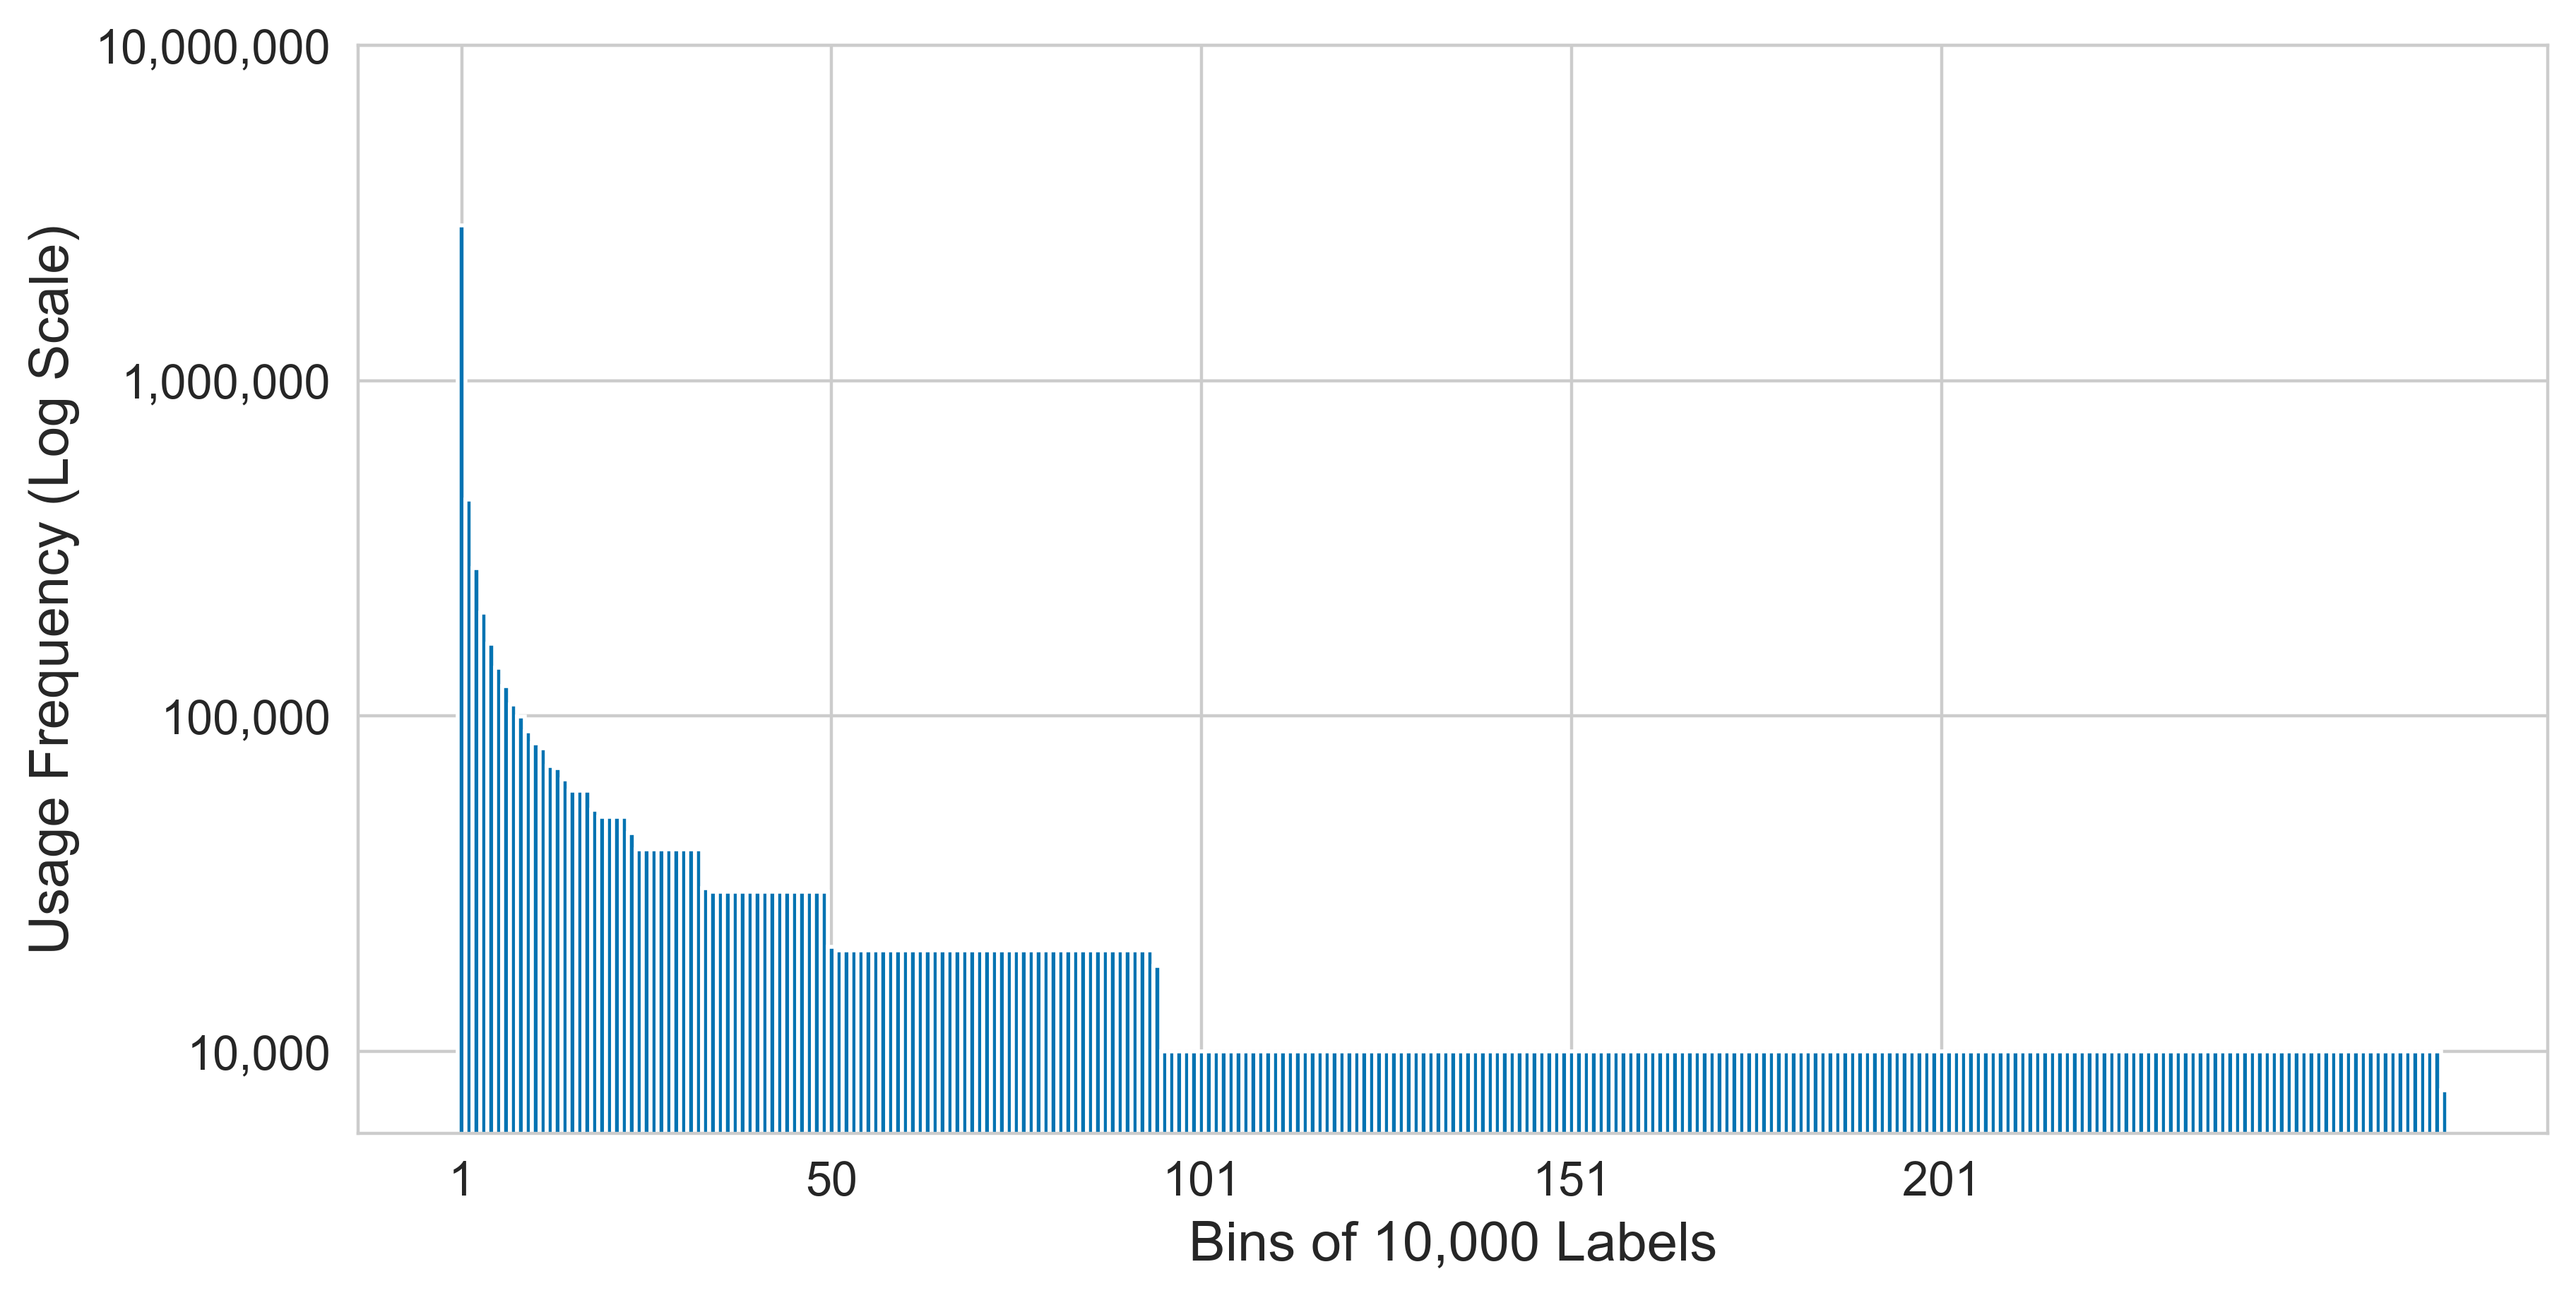

In [90]:
nb_of_bins = len(bins)
plt.figure(figsize=(10,5),dpi=200)
plt.rcParams.update({'font.size': 12,'axes.labelsize': 14})
ax=plt.bar([i for i in range(0,nb_of_bins)],height=list(bins["occurrences"]),width=1,color=sns.color_palette("colorblind",as_cmap=True)[0])
plt.yscale('log')
plt.xticks([0,50,100,150,200], ["1","50","101","151","201"])
plt.yticks(np.array([1.e+04, 1.e+05, 1.e+06, 1.e+07]),["10,000","100,000","1,000,000","10,000,000"])
plt.xlabel("Bins of 10,000 Labels")
plt.ylabel("Usage Frequency (Log Scale)")
plt.savefig(constants.FIGURES_ROOT / 'labels_usage.pdf',transparent=True,bbox_inches = 'tight')

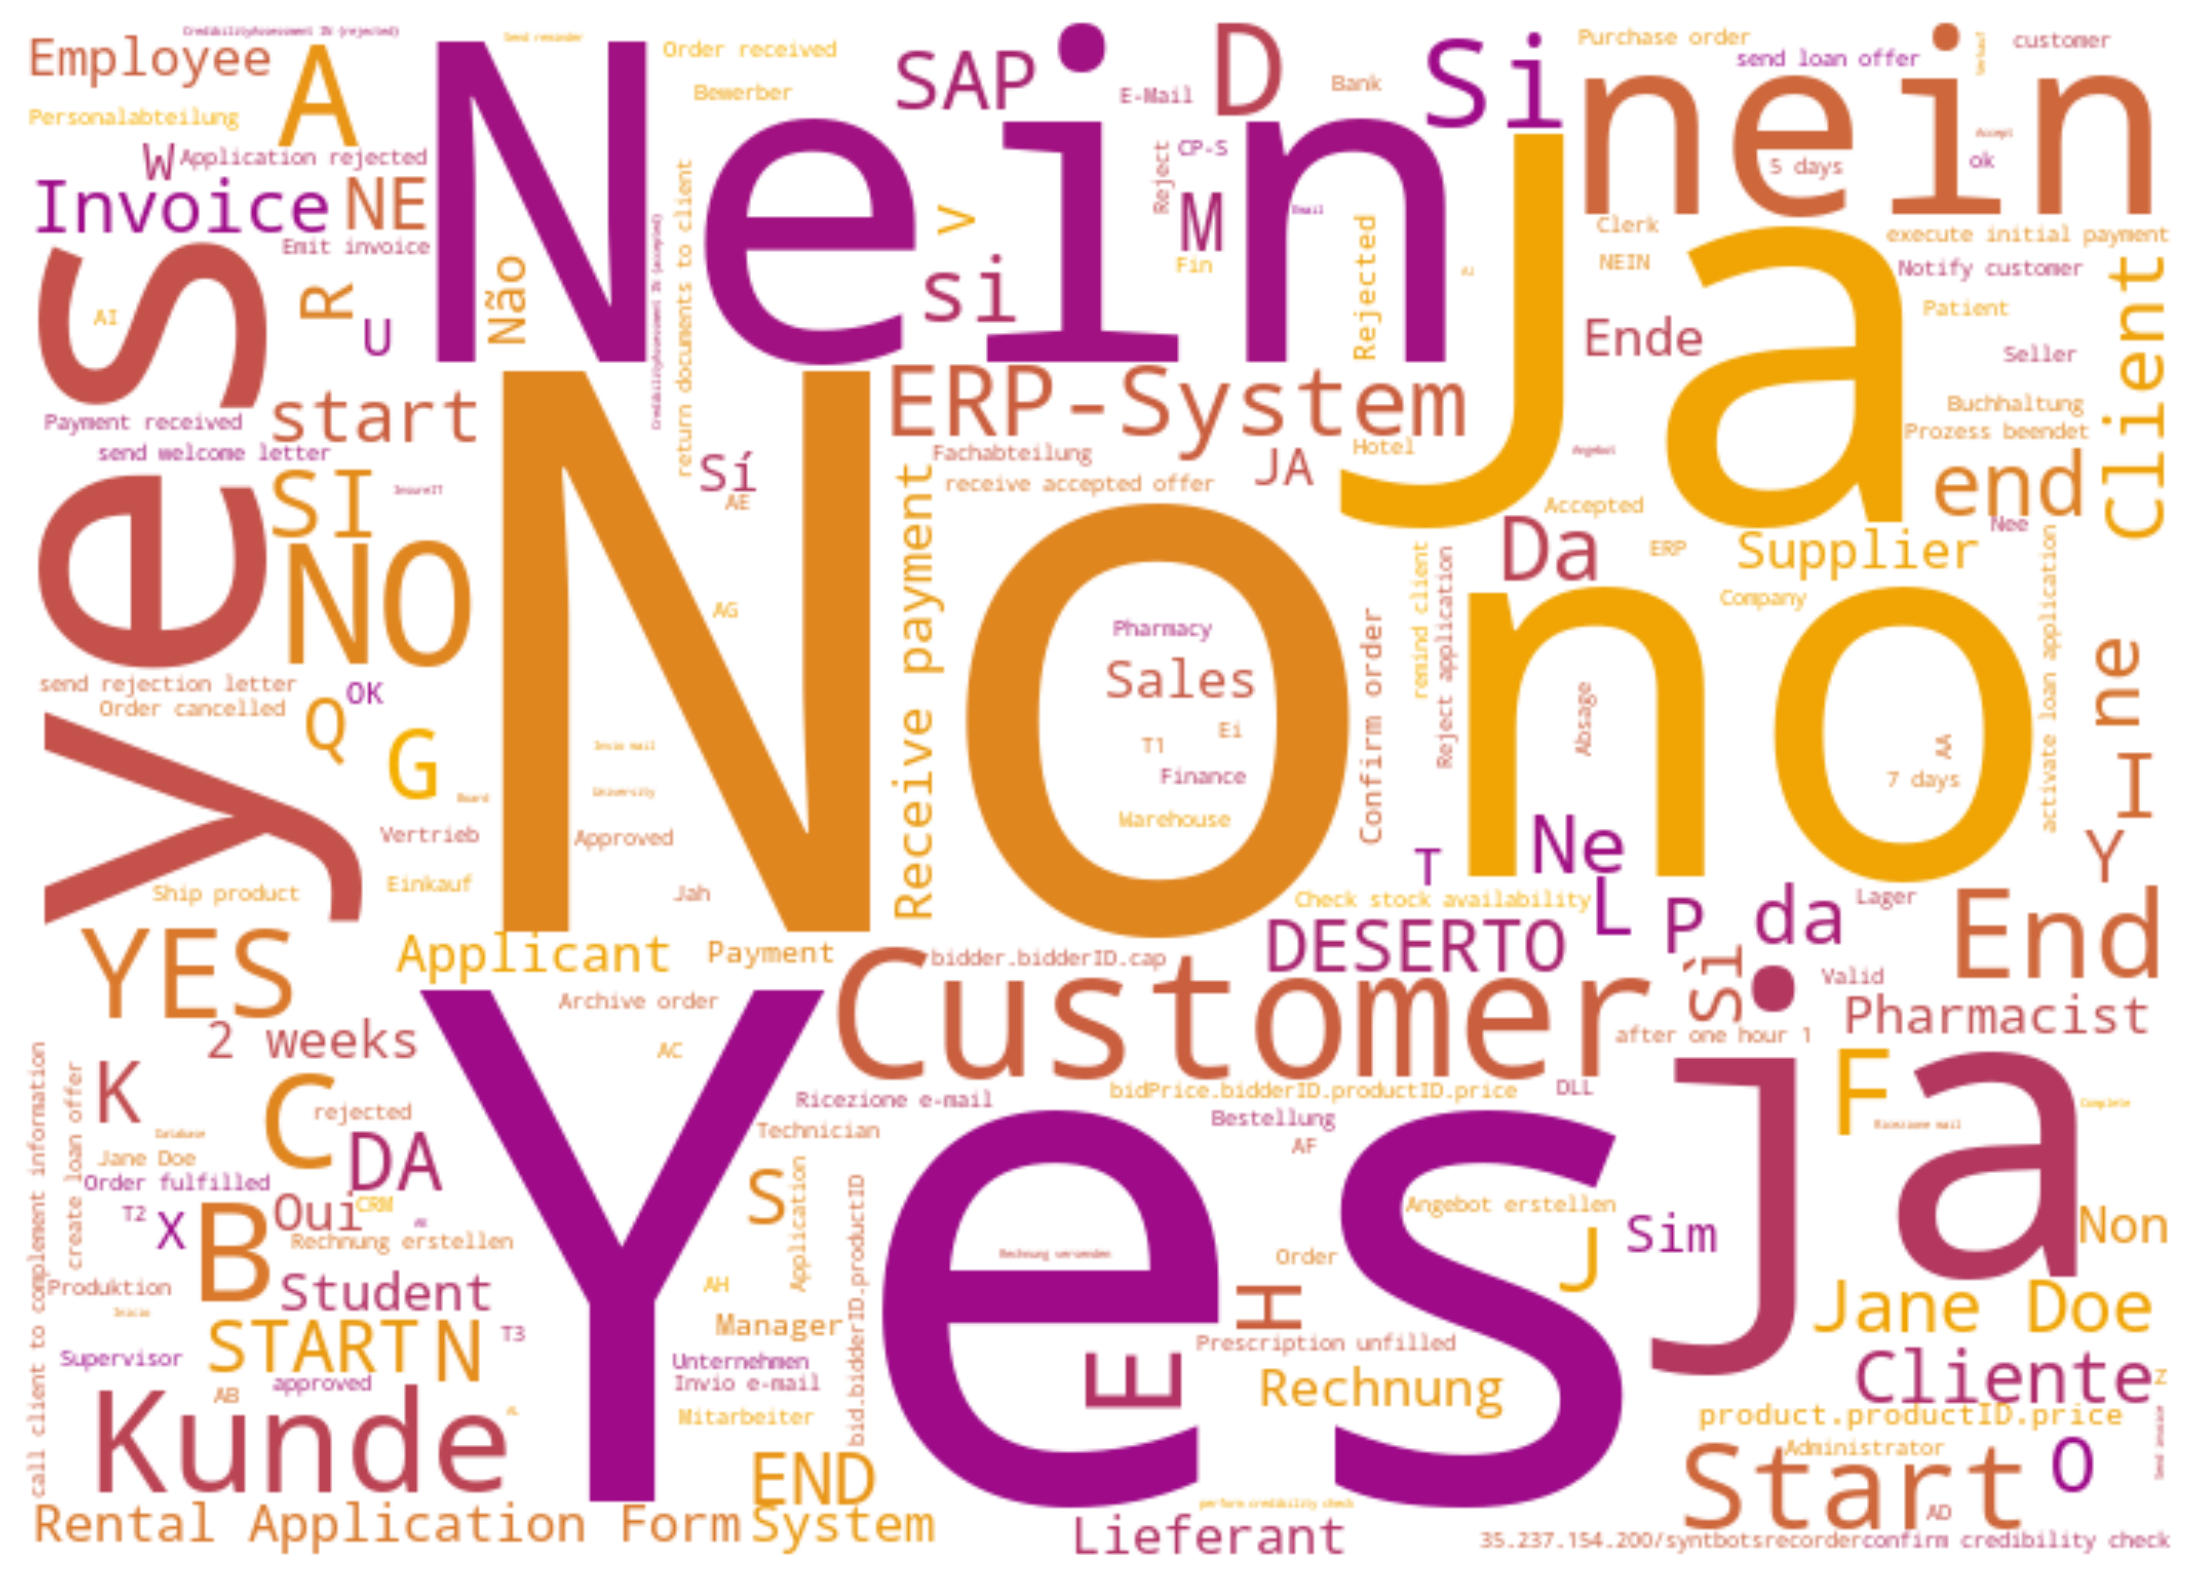

In [91]:
wordcloud_dict_labels = dict(zip(cnts_labels.label, cnts_labels.occurrences))
wordcloud_dict_labels = {k: v for k, v in wordcloud_dict_labels.items() if '\n' not in k}
wordcloud = WordCloud(min_word_length=2,background_color='white',width=700, height=500)
wordcloud.generate_from_frequencies(wordcloud_dict_labels)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud.recolor(color_func = color_func), interpolation='bilinear')
plt.axis('off')
plt.savefig(constants.FIGURES_ROOT / 'word_cloud_labels.pdf',transparent=True,bbox_inches = 'tight')
plt.show()